In [1]:
import numpy as np

def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def tanh(x):
    x = np.clip(x, -500, 500)
    return np.tanh(x)

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def tanh_derivative(x):
    return 1 - tanh(x)**2

class GRUCell:
    def __init__(self, input_dim, hidden_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Xavier/Glorot initialization
        limit = np.sqrt(6 / (input_dim + hidden_dim))
        self.Wz = np.random.uniform(-limit, limit, (hidden_dim, input_dim))
        self.Uz = np.random.uniform(-limit, limit, (hidden_dim, hidden_dim))
        self.bz = np.zeros((hidden_dim, 1))

        self.Wr = np.random.uniform(-limit, limit, (hidden_dim, input_dim))
        self.Ur = np.random.uniform(-limit, limit, (hidden_dim, hidden_dim))
        self.br = np.zeros((hidden_dim, 1))

        self.Wh = np.random.uniform(-limit, limit, (hidden_dim, input_dim))
        self.Uh = np.random.uniform(-limit, limit, (hidden_dim, hidden_dim))
        self.bh = np.zeros((hidden_dim, 1))

        # Adam optimizer parameters
        self.m = {param: np.zeros_like(getattr(self, param)) for param in ['Wz', 'Uz', 'bz', 'Wr', 'Ur', 'br', 'Wh', 'Uh', 'bh']}
        self.v = {param: np.zeros_like(getattr(self, param)) for param in ['Wz', 'Uz', 'bz', 'Wr', 'Ur', 'br', 'Wh', 'Uh', 'bh']}
        self.t = 0

        self.reset_gradients()

    def reset_gradients(self):
        self.dWz = np.zeros_like(self.Wz)
        self.dUz = np.zeros_like(self.Uz)
        self.dbz = np.zeros_like(self.bz)
        self.dWr = np.zeros_like(self.Wr)
        self.dUr = np.zeros_like(self.Ur)
        self.dbr = np.zeros_like(self.br)
        self.dWh = np.zeros_like(self.Wh)
        self.dUh = np.zeros_like(self.Uh)
        self.dbh = np.zeros_like(self.bh)

    def forward(self, x, h_prev):
        # Ensure x is 2D
        if x.ndim == 1:
            x = x.reshape(-1, 1)

        # Gerbang update
        self.z = sigmoid(np.dot(self.Wz, x) + np.dot(self.Uz, h_prev) + self.bz)

        # Gerbang reset
        self.r = sigmoid(np.dot(self.Wr, x) + np.dot(self.Ur, h_prev) + self.br)

        # Kandidat state tersembunyi
        self.h_tilde = tanh(np.dot(self.Wh, x) + np.dot(self.Uh, (self.r * h_prev)) + self.bh)

        # State tersembunyi akhir
        h = (1 - self.z) * h_prev + self.z * self.h_tilde

        self.x, self.h_prev, self.h = x, h_prev, h
        return h

    def backward(self, dh_next):
        dz = dh_next * (self.h_tilde - self.h_prev) * sigmoid_derivative(self.z)
        dh_tilde = dh_next * self.z * tanh_derivative(self.h_tilde)
        dr = dh_tilde * np.dot(self.Uh.T, self.h_prev) * sigmoid_derivative(self.r)

        self.dWz += np.dot(dz, self.x.T)
        self.dUz += np.dot(dz, self.h_prev.T)
        self.dbz += np.sum(dz, axis=1, keepdims=True)

        self.dWr += np.dot(dr, self.x.T)
        self.dUr += np.dot(dr, self.h_prev.T)
        self.dbr += np.sum(dr, axis=1, keepdims=True)

        self.dWh += np.dot(dh_tilde, self.x.T)
        self.dUh += np.dot(dh_tilde, (self.r * self.h_prev).T)
        self.dbh += np.sum(dh_tilde, axis=1, keepdims=True)

        dh_prev = (1 - self.z) * dh_next + np.dot(self.Uz.T, dz) + np.dot(self.Ur.T, dr) + np.dot(self.Uh.T, (dh_tilde * self.r))
        return dh_prev

    def update_weights(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.t += 1

        for param in ['Wz', 'Uz', 'bz', 'Wr', 'Ur', 'br', 'Wh', 'Uh', 'bh']:
            grad = getattr(self, 'd' + param)

            # Gradient clipping
            np.clip(grad, -1.0, 1.0, out=grad)

            # Adam update
            self.m[param] = beta1 * self.m[param] + (1 - beta1) * grad
            self.v[param] = beta2 * self.v[param] + (1 - beta2) * (grad ** 2)

            m_hat = self.m[param] / (1 - beta1 ** self.t)
            v_hat = self.v[param] / (1 - beta2 ** self.t)

            update = learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

            setattr(self, param, getattr(self, param) - update)
            # Print parameter after update
            print(f"Parameter {param} after update: {getattr(self, param)}")

        self.reset_gradients()

print("Fungsi Perhitungan GRU Sudah disiapkan")

Fungsi Perhitungan GRU Sudah disiapkan


Training data shape: (12, 10, 1)
Validation data shape: (4, 10, 1)
Testing data shape: (5, 10, 1)


Epoch 1/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 31.81it/s]


Parameter Wz after update: [[-0.22702701]
 [-0.09940384]
 [ 0.12553575]
 [-0.03569609]
 [ 0.02449831]
 [ 0.16761933]
 [ 0.07922585]
 [-0.07551027]
 [-0.16340144]
 [ 0.16717586]
 [ 0.01484892]
 [-0.09947277]
 [ 0.13233179]
 [-0.01416822]
 [ 0.00973297]
 [-0.12031602]
 [ 0.13953131]
 [ 0.00229195]
 [ 0.01928644]
 [-0.20136457]
 [ 0.22111196]
 [-0.0844646 ]
 [ 0.1506352 ]
 [ 0.05216383]
 [ 0.18148436]
 [ 0.01915224]
 [ 0.09890675]
 [ 0.20118265]
 [-0.19033888]
 [-0.21939275]
 [-0.23095181]
 [-0.20389791]
 [-0.23452685]
 [ 0.00538305]
 [ 0.22467897]
 [-0.16279719]
 [-0.05952747]
 [-0.2231207 ]
 [ 0.23056   ]
 [-0.0390999 ]
 [ 0.00502781]
 [ 0.00140139]
 [ 0.24129708]
 [ 0.19501261]
 [-0.13409121]
 [ 0.2118694 ]
 [-0.00473891]
 [ 0.06097778]
 [ 0.07604658]
 [ 0.20588372]
 [-0.19935554]
 [ 0.16795813]
 [-0.06458077]
 [-0.04649942]
 [-0.03760541]
 [ 0.13285127]
 [ 0.14865804]
 [ 0.11713781]
 [-0.10629831]
 [ 0.0932573 ]
 [-0.01028125]
 [-0.07681191]
 [ 0.04746141]
 [-0.02526825]
 [ 0.13111243

Epoch 2/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 56.43it/s]


Parameter Wz after update: [[-0.22802799]
 [-0.10038912]
 [ 0.12454283]
 [-0.03669614]
 [ 0.02350168]
 [ 0.16662568]
 [ 0.07824156]
 [-0.07451023]
 [-0.16240021]
 [ 0.16617771]
 [ 0.01385968]
 [-0.09847151]
 [ 0.13332404]
 [-0.01515028]
 [ 0.00875024]
 [-0.12100551]
 [ 0.1405325 ]
 [ 0.00329065]
 [ 0.02022609]
 [-0.20036773]
 [ 0.22118984]
 [-0.08546152]
 [ 0.14964087]
 [ 0.0511709 ]
 [ 0.18248523]
 [ 0.02015344]
 [ 0.09792495]
 [ 0.20023081]
 [-0.18933817]
 [-0.2183931 ]
 [-0.23000813]
 [-0.20289655]
 [-0.23352554]
 [ 0.00440606]
 [ 0.22368326]
 [-0.16379193]
 [-0.05852988]
 [-0.22219585]
 [ 0.22957235]
 [-0.0380989 ]
 [ 0.00602407]
 [ 0.0004077 ]
 [ 0.24029954]
 [ 0.19574445]
 [-0.13508926]
 [ 0.21088045]
 [-0.00571631]
 [ 0.05999284]
 [ 0.07700494]
 [ 0.20688402]
 [-0.19988359]
 [ 0.16697949]
 [-0.06358067]
 [-0.04633491]
 [-0.03859903]
 [ 0.13385003]
 [ 0.14965723]
 [ 0.11614997]
 [-0.10538059]
 [ 0.09425032]
 [-0.01126064]
 [-0.07593841]
 [ 0.04846266]
 [-0.02426872]
 [ 0.13211069

Epoch 3/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 53.53it/s]


Parameter Wz after update: [[-0.22902968]
 [-0.10134802]
 [ 0.12356156]
 [-0.03769536]
 [ 0.02251028]
 [ 0.16564177]
 [ 0.07728594]
 [-0.07350995]
 [-0.16139709]
 [ 0.16518236]
 [ 0.01289009]
 [-0.09746994]
 [ 0.13432214]
 [-0.01609449]
 [ 0.0078029 ]
 [-0.12099925]
 [ 0.14153554]
 [ 0.00429011]
 [ 0.02059622]
 [-0.19937451]
 [ 0.22179479]
 [-0.08645038]
 [ 0.14865533]
 [ 0.05019096]
 [ 0.18348804]
 [ 0.02115695]
 [ 0.09697798]
 [ 0.19936235]
 [-0.18833563]
 [-0.21739419]
 [-0.22907896]
 [-0.20189303]
 [-0.23252195]
 [ 0.00350246]
 [ 0.22269445]
 [-0.16477691]
 [-0.05753511]
 [-0.22128542]
 [ 0.22860953]
 [-0.03709631]
 [ 0.00701729]
 [-0.00057117]
 [ 0.23930705]
 [ 0.19657005]
 [-0.13608215]
 [ 0.2098886 ]
 [-0.00664111]
 [ 0.0590348 ]
 [ 0.07795189]
 [ 0.20788508]
 [-0.19961968]
 [ 0.16604713]
 [-0.06257931]
 [-0.0457293 ]
 [-0.03958229]
 [ 0.13484881]
 [ 0.15065527]
 [ 0.11517286]
 [-0.10446242]
 [ 0.09523791]
 [-0.01220333]
 [-0.07504587]
 [ 0.0494659 ]
 [-0.02327046]
 [ 0.13310656

Epoch 4/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 48.09it/s]


Parameter Wz after update: [[-0.23003143]
 [-0.10226688]
 [ 0.12259648]
 [-0.0386925 ]
 [ 0.02152603]
 [ 0.16467086]
 [ 0.07637461]
 [-0.07250809]
 [-0.16039142]
 [ 0.16419069]
 [ 0.01195222]
 [-0.09647084]
 [ 0.13530475]
 [-0.01697192]
 [ 0.00691889]
 [-0.1205407 ]
 [ 0.14254113]
 [ 0.00529195]
 [ 0.02028218]
 [-0.19838642]
 [ 0.22255277]
 [-0.0874224 ]
 [ 0.14768226]
 [ 0.04922987]
 [ 0.18449379]
 [ 0.02216362]
 [ 0.09608846]
 [ 0.19861403]
 [-0.18733009]
 [-0.21639602]
 [-0.22814887]
 [-0.20088664]
 [-0.23151524]
 [ 0.00278127]
 [ 0.22171501]
 [-0.16574763]
 [-0.05654103]
 [-0.22037376]
 [ 0.22768849]
 [-0.03609161]
 [ 0.00800883]
 [-0.00151701]
 [ 0.23832451]
 [ 0.19744219]
 [-0.13706474]
 [ 0.20888984]
 [-0.00744551]
 [ 0.05811744]
 [ 0.07889701]
 [ 0.20888629]
 [-0.19901662]
 [ 0.16519744]
 [-0.06157522]
 [-0.04496966]
 [-0.04055064]
 [ 0.13584951]
 [ 0.15165327]
 [ 0.1142126 ]
 [-0.10353184]
 [ 0.09622351]
 [-0.01309051]
 [-0.07413379]
 [ 0.0504718 ]
 [-0.02227395]
 [ 0.13409959

Epoch 5/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 42.72it/s]


Parameter Wz after update: [[-0.23103256]
 [-0.10313115]
 [ 0.12165213]
 [-0.03968624]
 [ 0.02055107]
 [ 0.16371589]
 [ 0.07552627]
 [-0.07150292]
 [-0.15938256]
 [ 0.1632037 ]
 [ 0.01106012]
 [-0.09547875]
 [ 0.13618603]
 [-0.01774387]
 [ 0.00613913]
 [-0.11987504]
 [ 0.14354998]
 [ 0.00629761]
 [ 0.01968084]
 [-0.1974024 ]
 [ 0.22338303]
 [-0.08835982]
 [ 0.14672581]
 [ 0.04829304]
 [ 0.18550348]
 [ 0.02317418]
 [ 0.09528574]
 [ 0.19801175]
 [-0.18632046]
 [-0.2153978 ]
 [-0.22721099]
 [-0.19987671]
 [-0.23050459]
 [ 0.00239927]
 [ 0.2207476 ]
 [-0.16670002]
 [-0.05554518]
 [-0.21945438]
 [ 0.2268349 ]
 [-0.03508437]
 [ 0.00900047]
 [-0.00238683]
 [ 0.23736109]
 [ 0.19834669]
 [-0.13802934]
 [ 0.20788687]
 [-0.00800092]
 [ 0.05725541]
 [ 0.07984628]
 [ 0.20988769]
 [-0.19827162]
 [ 0.16447835]
 [-0.06056708]
 [-0.04414405]
 [-0.04149935]
 [ 0.1368538 ]
 [ 0.15265276]
 [ 0.11328727]
 [-0.10258634]
 [ 0.09721059]
 [-0.01390297]
 [-0.0732032 ]
 [ 0.05148101]
 [-0.02127946]
 [ 0.13508968

Epoch 6/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 57.00it/s]


Parameter Wz after update: [[-0.23203252]
 [-0.10392706]
 [ 0.12073305]
 [-0.04067493]
 [ 0.01958812]
 [ 0.16277929]
 [ 0.07476255]
 [-0.07049287]
 [-0.15836994]
 [ 0.16222285]
 [ 0.01023028]
 [-0.09450015]
 [ 0.13677167]
 [-0.01836211]
 [ 0.00551714]
 [-0.11909964]
 [ 0.1445628 ]
 [ 0.00730834]
 [ 0.01894989]
 [-0.19641823]
 [ 0.22425827]
 [-0.08922853]
 [ 0.14579063]
 [ 0.0473852 ]
 [ 0.18651802]
 [ 0.02418938]
 [ 0.09460545]
 [ 0.19756485]
 [-0.18530578]
 [-0.21439815]
 [-0.22626277]
 [-0.19886255]
 [-0.22948926]
 [ 0.00243415]
 [ 0.21979584]
 [-0.16763031]
 [-0.05454544]
 [-0.21852412]
 [ 0.22608571]
 [-0.03407409]
 [ 0.00999406]
 [-0.00309084]
 [ 0.23643329]
 [ 0.19927706]
 [-0.13896421]
 [ 0.20688833]
 [-0.0081749 ]
 [ 0.05646223]
 [ 0.080803  ]
 [ 0.2108901 ]
 [-0.19744955]
 [ 0.16394137]
 [-0.05955375]
 [-0.04335247]
 [-0.04242337]
 [ 0.1378631 ]
 [ 0.1536551 ]
 [ 0.11244604]
 [-0.10162555]
 [ 0.09820189]
 [-0.0146238 ]
 [-0.07225543]
 [ 0.05249418]
 [-0.02028695]
 [ 0.13607716

Epoch 7/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.23303077]
 [-0.10464253]
 [ 0.11984381]
 [-0.04165625]
 [ 0.01864067]
 [ 0.16186293]
 [ 0.07410702]
 [-0.06947671]
 [-0.157353  ]
 [ 0.16125028]
 [ 0.00948434]
 [-0.09354279]
 [ 0.1369063 ]
 [-0.01877426]
 [ 0.00510863]
 [-0.11825512]
 [ 0.14558028]
 [ 0.00832523]
 [ 0.01814558]
 [-0.19542772]
 [ 0.22516665]
 [-0.08997013]
 [ 0.14488169]
 [ 0.0465103 ]
 [ 0.18753829]
 [ 0.02520988]
 [ 0.0940862 ]
 [ 0.19726793]
 [-0.18428519]
 [-0.21339536]
 [-0.22530351]
 [-0.19784345]
 [-0.22846856]
 [ 0.00280364]
 [ 0.21886474]
 [-0.16853484]
 [-0.05354012]
 [-0.21758149]
 [ 0.225492  ]
 [-0.03306014]
 [ 0.01099141]
 [-0.0034993 ]
 [ 0.235572  ]
 [ 0.20022952]
 [-0.13985128]
 [ 0.20591019]
 [-0.00797414]
 [ 0.05574803]
 [ 0.08176886]
 [ 0.2118948 ]
 [-0.19657707]
 [ 0.16362326]
 [-0.05853428]
 [-0.04284888]
 [-0.04331734]
 [ 0.13887856]
 [ 0.1546614 ]
 [ 0.11181594]
 [-0.10064966]
 [ 0.09919947]
 [-0.01524104]
 [-0.07129214]
 [ 0.05351197]
 [-0.01929602]
 [ 0.13706308

Epoch 7/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 53.03it/s]


Parameter Uz after update: [[-0.04530293 -0.15487257  0.03296356 ... -0.02410762 -0.01720725
   0.01068016]
 [ 0.21198675 -0.22597688  0.20335005 ...  0.01228549 -0.02320106
  -0.22633102]
 [ 0.19422339 -0.01786008 -0.18486144 ...  0.12100942  0.05000666
  -0.13742885]
 ...
 [-0.05433253 -0.06561921 -0.03794366 ...  0.2168262  -0.22145494
  -0.12975391]
 [ 0.16866695 -0.19276009  0.2342082  ...  0.14179816 -0.21940985
   0.07063515]
 [-0.19583305 -0.21721648  0.0492216  ... -0.01041462  0.05850274
  -0.00724041]]
Parameter bz after update: [[-0.00704926]
 [-0.00643129]
 [-0.00657646]
 [-0.00699569]
 [ 0.00704489]
 [-0.00676434]
 [-0.00554863]
 [ 0.00678962]
 [ 0.00705077]
 [-0.00695845]
 [-0.00633921]
 [ 0.0070007 ]
 [ 0.005569  ]
 [-0.00459553]
 [-0.00499575]
 [-0.00415936]
 [ 0.00705601]
 [ 0.00691162]
 [ 0.00213129]
 [ 0.00685568]
 [-0.00241902]
 [-0.00457693]
 [-0.00672313]
 [-0.0066172 ]
 [ 0.0070463 ]
 [ 0.00705855]
 [ 0.00185088]
 [ 0.00668156]
 [ 0.0070397 ]
 [ 0.00697693]
 [ 0

Epoch 8/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 42.43it/s]

Parameter Wz after update: [[-0.23402657]
 [-0.10526676]
 [ 0.11898915]
 [-0.04262667]
 [ 0.0177133 ]
 [ 0.16096812]
 [ 0.07358331]
 [-0.06845345]
 [-0.15633115]
 [ 0.160289  ]
 [ 0.00885369]
 [-0.0926141 ]
 [ 0.13666003]
 [-0.01893987]
 [ 0.00495038]
 [-0.11736137]
 [ 0.14660303]
 [ 0.00934919]
 [ 0.01729217]
 [-0.19442563]
 [ 0.22610222]
 [-0.0905012 ]
 [ 0.14400415]
 [ 0.04567171]
 [ 0.18856508]
 [ 0.02623639]
 [ 0.0937617 ]
 [ 0.19710622]
 [-0.18325793]
 [-0.21238753]
 [-0.22433315]
 [-0.19681863]
 [-0.22744182]
 [ 0.00338528]
 [ 0.21796108]
 [-0.16940996]
 [-0.05252775]
 [-0.21662584]
 [ 0.2251205 ]
 [-0.03204171]
 [ 0.01199411]
 [-0.0035387 ]
 [ 0.23483466]
 [ 0.20120163]
 [-0.14066274]
 [ 0.20497978]
 [-0.00750877]
 [ 0.05511739]
 [ 0.08274486]
 [ 0.2129032 ]
 [-0.19566722]
 [ 0.16353042]
 [-0.0575079 ]
 [-0.04287167]
 [-0.04417555]
 [ 0.13990115]
 [ 0.15567255]
 [ 0.11159364]
 [-0.099659  ]
 [ 0.10020481]
 [-0.01574989]
 [-0.07031496]
 [ 0.05453512]
 [-0.01830592]
 [ 0.13804925

Epoch 8/50, Train Loss: 0.8306, Val Loss: 0.7434


Epoch 9/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.23501872]
 [-0.1057897 ]
 [ 0.11817388]
 [-0.04358065]
 [ 0.01681187]
 [ 0.16009577]
 [ 0.07321232]
 [-0.06742224]
 [-0.15530375]
 [ 0.15934296]
 [ 0.00838365]
 [-0.09171871]
 [ 0.13616776]
 [-0.01885003]
 [ 0.00504346]
 [-0.11642972]
 [ 0.14763162]
 [ 0.01038106]
 [ 0.01640145]
 [-0.19341063]
 [ 0.22706153]
 [-0.09074138]
 [ 0.14316328]
 [ 0.04487243]
 [ 0.18959914]
 [ 0.02726967]
 [ 0.09365028]
 [ 0.19706023]
 [-0.18222337]
 [-0.21137269]
 [-0.22335182]
 [-0.19578731]
 [-0.22640835]
 [ 0.00409602]
 [ 0.21709357]
 [-0.17025188]
 [-0.05150715]
 [-0.21565682]
 [ 0.22503649]
 [-0.03101783]
 [ 0.01300357]
 [-0.00325871]
 [ 0.23431346]
 [ 0.20219174]
 [-0.14135654]
 [ 0.20414349]
 [-0.00687482]
 [ 0.05456817]
 [ 0.08373182]
 [ 0.21391666]
 [-0.19472715]
 [ 0.1636404 ]
 [-0.05647396]
 [-0.0432699 ]
 [-0.04499176]
 [ 0.14093173]
 [ 0.1566894 ]
 [ 0.1118049 ]
 [-0.09865401]
 [ 0.10121906]
 [-0.01615358]
 [-0.06932528]
 [ 0.05556435]
 [-0.01731553]
 [ 0.13903821

Epoch 9/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 45.73it/s]


Parameter Uz after update: [[-0.04735559 -0.15448469  0.03480855 ... -0.02545751 -0.01554415
   0.0086228 ]
 [ 0.21053591 -0.22789046  0.2047326  ...  0.01066885 -0.0213123
  -0.22781244]
 [ 0.19316198 -0.016295   -0.18484731 ...  0.12245173  0.04821019
  -0.13904719]
 ...
 [-0.05626835 -0.06764191 -0.03599781 ...  0.2148168  -0.21948031
  -0.13154235]
 [ 0.17053127 -0.19459682  0.23500756 ...  0.13994489 -0.21753938
   0.07268713]
 [-0.19379304 -0.21579674  0.04731792 ... -0.00840364  0.05656882
  -0.00517873]]
Parameter bz after update: [[-0.00908734]
 [-0.00781375]
 [-0.00813103]
 [-0.00898768]
 [ 0.00909292]
 [-0.00853285]
 [-0.0057735 ]
 [ 0.0087779 ]
 [ 0.00910504]
 [-0.00889648]
 [-0.00740279]
 [ 0.00896084]
 [ 0.00504568]
 [-0.00388737]
 [-0.00452536]
 [-0.00332359]
 [ 0.00911492]
 [ 0.00893269]
 [ 0.00055816]
 [ 0.00881491]
 [-0.00095302]
 [-0.00353403]
 [-0.00840885]
 [-0.00821933]
 [ 0.00909952]
 [ 0.00912093]
 [ 0.00372085]
 [ 0.00826254]
 [ 0.00909819]
 [ 0.0089766 ]
 [ 0.

Epoch 10/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.2360054 ]
 [-0.10620197]
 [ 0.11740271]
 [-0.04450932]
 [ 0.01594372]
 [ 0.15924648]
 [ 0.07300881]
 [-0.06638238]
 [-0.15426999]
 [ 0.15841719]
 [ 0.00812904]
 [-0.09085569]
 [ 0.13551913]
 [-0.01853091]
 [ 0.0053575 ]
 [-0.11546742]
 [ 0.14866654]
 [ 0.01142156]
 [ 0.0154794 ]
 [-0.19238576]
 [ 0.22804231]
 [-0.09066776]
 [ 0.14236423]
 [ 0.04411536]
 [ 0.19064109]
 [ 0.02831052]
 [ 0.09374856]
 [ 0.19710847]
 [-0.18118094]
 [-0.210349  ]
 [-0.22235962]
 [-0.1947487 ]
 [-0.22536737]
 [ 0.00488934]
 [ 0.21627227]
 [-0.17105661]
 [-0.05047733]
 [-0.21467416]
 [ 0.22525596]
 [-0.02998753]
 [ 0.01402104]
 [-0.00275397]
 [ 0.2341047 ]
 [ 0.2031987 ]
 [-0.14187367]
 [ 0.20348025]
 [-0.00613003]
 [ 0.05409155]
 [ 0.08473056]
 [ 0.21493652]
 [-0.19376107]
 [ 0.1639161 ]
 [-0.05543191]
 [-0.04386983]
 [-0.04575907]
 [ 0.14197105]
 [ 0.15771285]
 [ 0.11229719]
 [-0.09763523]
 [ 0.10224318]
 [-0.01646304]
 [-0.06832416]
 [ 0.05660038]
 [-0.01632338]
 [ 0.14003301

Epoch 10/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 42.42it/s]


Parameter Uz after update: [[-0.04838771 -0.15469314  0.035649   ... -0.02605849 -0.0146451
   0.00758329]
 [ 0.20990259 -0.22881132  0.20534862 ...  0.00990086 -0.02043103
  -0.22843961]
 [ 0.19276417 -0.01556638 -0.18501214 ...  0.12326194  0.04733694
  -0.13978185]
 ...
 [-0.05726755 -0.0686605  -0.03501019 ...  0.21379241 -0.21848251
  -0.13248944]
 [ 0.17150576 -0.19540669  0.23561952 ...  0.13897376 -0.21677537
   0.0737246 ]
 [-0.19276592 -0.21496335  0.04640229 ... -0.00738434  0.05558242
  -0.00413625]]
Parameter bz after update: [[-1.01065387e-02]
 [-8.39257173e-03]
 [-8.82900247e-03]
 [-9.97468151e-03]
 [ 1.01287991e-02]
 [-9.38116485e-03]
 [-5.58619877e-03]
 [ 9.78957736e-03]
 [ 1.01431320e-02]
 [-9.84098807e-03]
 [-7.63123122e-03]
 [ 9.92940006e-03]
 [ 4.47680480e-03]
 [-3.26994468e-03]
 [-3.99794845e-03]
 [-2.68994117e-03]
 [ 1.01551061e-02]
 [ 9.95891624e-03]
 [-3.14536732e-04]
 [ 9.82107426e-03]
 [-1.04915815e-04]
 [-2.80297713e-03]
 [-9.18682031e-03]
 [-8.95334689e-03]

Epoch 11/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-2.36983718e-01]
 [-1.06495582e-01]
 [ 1.16680011e-01]
 [-4.53981380e-02]
 [ 1.51174817e-02]
 [ 1.58420605e-01]
 [ 7.29791377e-02]
 [-6.53331947e-02]
 [-1.53228943e-01]
 [ 1.57517748e-01]
 [ 8.13068713e-03]
 [-9.00160983e-02]
 [ 1.34764456e-01]
 [-1.80267949e-02]
 [ 5.84944659e-03]
 [-1.14479506e-01]
 [ 1.49708131e-01]
 [ 1.24713125e-02]
 [ 1.45290566e-02]
 [-1.91355870e-01]
 [ 2.29042907e-01]
 [-9.03265452e-02]
 [ 1.41611827e-01]
 [ 4.34033890e-02]
 [ 1.91691493e-01]
 [ 2.93598051e-02]
 [ 9.40346538e-02]
 [ 1.97228851e-01]
 [-1.80130268e-01]
 [-2.09314958e-01]
 [-2.21356523e-01]
 [-1.93702082e-01]
 [-2.24318033e-01]
 [ 5.73975091e-03]
 [ 2.15507225e-01]
 [-1.71819859e-01]
 [-4.94374682e-02]
 [-2.13677493e-01]
 [ 2.25724325e-01]
 [-2.89498572e-02]
 [ 1.50477185e-02]
 [-2.09807184e-03]
 [ 2.34231380e-01]
 [ 2.04221635e-01]
 [-1.42146823e-01]
 [ 2.03105602e-01]
 [-5.30704496e-03]
 [ 5.36731024e-02]
 [ 8.57419296e-02]
 [ 2.15964109e-01]
 [-1.92771630e-01]
 [ 1

Epoch 11/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 35.88it/s]


Parameter Uz after update: [[-0.04942031 -0.15510382  0.03640995 ... -0.02665418 -0.0137092
   0.00653779]
 [ 0.20933575 -0.22967046  0.20592002 ...  0.0091609  -0.01962194
  -0.22897312]
 [ 0.19244609 -0.01487334 -0.18525566 ...  0.12410511  0.04648179
  -0.14046143]
 ...
 [-0.05828361 -0.06968853 -0.03402912 ...  0.21275552 -0.21747168
  -0.13346532]
 [ 0.17250114 -0.19607583  0.23633606 ...  0.13798224 -0.2162587
   0.07476894]
 [-0.19173284 -0.21407705  0.04552351 ... -0.00635255  0.05458273
  -0.00308494]]
Parameter bz after update: [[-0.01112201]
 [-0.00888796]
 [-0.0094704 ]
 [-0.01094216]
 [ 0.0111735 ]
 [-0.01020466]
 [-0.00522788]
 [ 0.01081365]
 [ 0.01118994]
 [-0.01076089]
 [-0.00760386]
 [ 0.01089477]
 [ 0.00378405]
 [-0.00253912]
 [-0.00333906]
 [-0.00195889]
 [ 0.01120311]
 [ 0.01099656]
 [-0.001229  ]
 [ 0.01083768]
 [ 0.00079454]
 [-0.00199173]
 [-0.00991595]
 [-0.00963885]
 [ 0.01117797]
 [ 0.01121529]
 [ 0.00569714]
 [ 0.00963461]
 [ 0.01118999]
 [ 0.01099765]
 [ 0.0

Epoch 12/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.23794894]
 [-0.10666518]
 [ 0.11600944]
 [-0.04622246]
 [ 0.01434252]
 [ 0.15761832]
 [ 0.07312092]
 [-0.06427409]
 [-0.15217962]
 [ 0.15665164]
 [ 0.00838667]
 [-0.08918261]
 [ 0.13393259]
 [-0.01738159]
 [ 0.00647864]
 [-0.11346964]
 [ 0.15075649]
 [ 0.0135308 ]
 [ 0.01355192]
 [-0.19032436]
 [ 0.23006213]
 [-0.08978747]
 [ 0.14091012]
 [ 0.04273937]
 [ 0.19275084]
 [ 0.03041836]
 [ 0.09447763]
 [ 0.19739941]
 [-0.17907124]
 [-0.20826953]
 [-0.22034212]
 [-0.19264685]
 [-0.22325948]
 [ 0.00663329]
 [ 0.21480621]
 [-0.17253695]
 [-0.04838683]
 [-0.21266623]
 [ 0.22636242]
 [-0.02790407]
 [ 0.01608488]
 [-0.00133702]
 [ 0.23463013]
 [ 0.20525977]
 [-0.14213225]
 [ 0.20310103]
 [-0.00442494]
 [ 0.05329411]
 [ 0.08676686]
 [ 0.21700081]
 [-0.19176063]
 [ 0.1648091 ]
 [-0.0533217 ]
 [-0.04539011]
 [-0.04711431]
 [ 0.14407858]
 [ 0.15978392]
 [ 0.11370343]
 [-0.0955585 ]
 [ 0.10432436]
 [-0.0168716 ]
 [-0.06628938]
 [ 0.05869526]
 [-0.01432661]
 [ 0.14205263

Epoch 12/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 42.42it/s]

Parameter Uz after update: [[-0.0504483  -0.15566388  0.0370758  ... -0.02728177 -0.01274022
   0.00548927]
 [ 0.20883905 -0.23042182  0.20645241 ...  0.00845394 -0.01892012
  -0.22939734]
 [ 0.19219677 -0.01421642 -0.18555211 ...  0.12496409  0.04564831
  -0.14108374]
 ...
 [-0.05931209 -0.07072914 -0.03306951 ...  0.21170627 -0.21644492
  -0.13446598]
 [ 0.1735135  -0.19653078  0.23713624 ...  0.13698027 -0.216083
   0.07582014]
 [-0.19069284 -0.21314958  0.04469704 ... -0.0053074   0.05356954
  -0.00202415]]
Parameter bz after update: [[-0.01212824]
 [-0.0092942 ]
 [-0.01005448]
 [-0.01186044]
 [ 0.01222638]
 [-0.01100308]
 [-0.00472565]
 [ 0.01185076]
 [ 0.01224644]
 [-0.01164883]
 [-0.0073283 ]
 [ 0.01186303]
 [ 0.00300186]
 [-0.00172473]
 [-0.00258193]
 [-0.00115228]
 [ 0.01225915]
 [ 0.01204619]
 [-0.00217983]
 [ 0.0118575 ]
 [ 0.00173519]
 [-0.0011211 ]
 [-0.01059341]
 [-0.01027319]
 [ 0.01222691]
 [ 0.01227558]
 [ 0.0067158 ]
 [ 0.01024969]
 [ 0.01224901]
 [ 0.01201893]
 [ 0.0

Epoch 12/50, Train Loss: 0.5782, Val Loss: 0.5628


Epoch 13/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 46.35it/s]


Parameter Wz after update: [[-0.23889334]
 [-0.1067094 ]
 [ 0.11539356]
 [-0.04694007]
 [ 0.01362753]
 [ 0.15683981]
 [ 0.07342405]
 [-0.06320459]
 [-0.1511211 ]
 [ 0.15582643]
 [ 0.00885496]
 [-0.08833325]
 [ 0.13304155]
 [-0.01663026]
 [ 0.00721271]
 [-0.11244057]
 [ 0.15181128]
 [ 0.01460026]
 [ 0.01254901]
 [-0.18929163]
 [ 0.23109915]
 [-0.08910823]
 [ 0.14026197]
 [ 0.04212603]
 [ 0.19381965]
 [ 0.03148699]
 [ 0.09504581]
 [ 0.19759945]
 [-0.17800426]
 [-0.20721215]
 [-0.21931544]
 [-0.19158263]
 [-0.22219097]
 [ 0.00756255]
 [ 0.21417188]
 [-0.17320284]
 [-0.04732473]
 [-0.21163952]
 [ 0.22710962]
 [-0.02684975]
 [ 0.01713398]
 [-0.00049859]
 [ 0.23521887]
 [ 0.20631221]
 [-0.14184267]
 [ 0.20342227]
 [-0.00349548]
 [ 0.05293366]
 [ 0.08780639]
 [ 0.21804817]
 [-0.19072964]
 [ 0.16535321]
 [-0.052253  ]
 [-0.0462543 ]
 [-0.04768164]
 [ 0.14514774]
 [ 0.1608341 ]
 [ 0.11452585]
 [-0.09450219]
 [ 0.10538299]
 [-0.01701323]
 [-0.06525483]
 [ 0.05975465]
 [-0.01331827]
 [ 0.14308253

Epoch 14/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.23980433]
 [-0.1066321 ]
 [ 0.11483354]
 [-0.0474841 ]
 [ 0.01297819]
 [ 0.15608574]
 [ 0.07387201]
 [-0.06212449]
 [-0.15005276]
 [ 0.15504954]
 [ 0.00948278]
 [-0.08744937]
 [ 0.13210459]
 [-0.01579797]
 [ 0.00802741]
 [-0.11139448]
 [ 0.15287134]
 [ 0.01567944]
 [ 0.01152199]
 [-0.18825496]
 [ 0.23215337]
 [-0.08832768]
 [ 0.13966884]
 [ 0.04156588]
 [ 0.19489867]
 [ 0.0325664 ]
 [ 0.09571037]
 [ 0.19781218]
 [-0.17693071]
 [-0.20614283]
 [-0.21827484]
 [-0.19050945]
 [-0.22111199]
 [ 0.00852421]
 [ 0.21359996]
 [-0.17381211]
 [-0.04625047]
 [-0.2105962 ]
 [ 0.22793074]
 [-0.0257871 ]
 [ 0.01819664]
 [ 0.00040003]
 [ 0.23593736]
 [ 0.20737749]
 [-0.14133508]
 [ 0.20396679]
 [-0.00252656]
 [ 0.05257205]
 [ 0.08886155]
 [ 0.21910803]
 [-0.18968062]
 [ 0.16591273]
 [-0.05117543]
 [-0.04717151]
 [-0.04815699]
 [ 0.14622738]
 [ 0.16189602]
 [ 0.11540221]
 [-0.09343631]
 [ 0.10645455]
 [-0.01713767]
 [-0.06420683]
 [ 0.06082141]
 [-0.01230143]
 [ 0.14412771

Epoch 14/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 44.05it/s]


Parameter Uz after update: [[-5.24467708e-02 -1.57064180e-01  3.81218230e-02 ... -2.87130988e-02
  -1.07298806e-02  3.42110795e-03]
 [ 2.08065712e-01 -2.31365091e-01  2.07426575e-01 ...  7.18541112e-03
  -1.80107576e-02 -2.29863907e-01]
 [ 1.91851490e-01 -1.30174279e-02 -1.86207037e-01 ...  1.26655702e-01
   4.40742665e-02 -1.42156262e-01]
 ...
 [-6.13735407e-02 -7.28500717e-02 -3.12603889e-02 ...  2.09571244e-01
  -2.14343986e-01 -1.36513284e-01]
 [ 1.75585656e-01 -1.96599201e-01  2.38923616e-01 ...  1.35039839e-01
  -2.16672674e-01  7.79470305e-02]
 [-1.88590127e-01 -2.11197966e-01  4.33014088e-02 ... -3.18037476e-03
   5.15006367e-02  1.28079793e-04]]
Parameter bz after update: [[-1.40681473e-02]
 [-9.82727283e-03]
 [-1.10562211e-02]
 [-1.31721635e-02]
 [ 1.43305924e-02]
 [-1.25235508e-02]
 [-3.38971463e-03]
 [ 1.39667254e-02]
 [ 1.43914796e-02]
 [-1.32989058e-02]
 [-6.21532187e-03]
 [ 1.38338799e-02]
 [ 1.26046196e-03]
 [ 8.26575690e-05]
 [-8.60486554e-04]
 [ 6.30313845e-04]
 [ 1.4

Epoch 15/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24066269]
 [-0.10644347]
 [ 0.11432892]
 [-0.04777461]
 [ 0.0123939 ]
 [ 0.15535798]
 [ 0.07444297]
 [-0.06103424]
 [-0.14897464]
 [ 0.15432716]
 [ 0.01022719]
 [-0.08652294]
 [ 0.13113555]
 [-0.01490237]
 [ 0.00890402]
 [-0.11033343]
 [ 0.15393388]
 [ 0.01676691]
 [ 0.01047553]
 [-0.18720923]
 [ 0.23322392]
 [-0.0874707 ]
 [ 0.13913116]
 [ 0.04106101]
 [ 0.19598899]
 [ 0.03365712]
 [ 0.09644445]
 [ 0.19802689]
 [-0.17585402]
 [-0.20506279]
 [-0.21721807]
 [-0.18942833]
 [-0.22002256]
 [ 0.00951741]
 [ 0.2130817 ]
 [-0.17435889]
 [-0.04516358]
 [-0.20953508]
 [ 0.22880898]
 [-0.02471765]
 [ 0.01927405]
 [ 0.00134731]
 [ 0.236749  ]
 [ 0.20845266]
 [-0.14067119]
 [ 0.2046579 ]
 [-0.00152426]
 [ 0.05219644]
 [ 0.08993293]
 [ 0.22018241]
 [-0.18861733]
 [ 0.16644779]
 [-0.05009018]
 [-0.04813283]
 [-0.04852209]
 [ 0.1473168 ]
 [ 0.16297127]
 [ 0.11632467]
 [-0.09236433]
 [ 0.10753916]
 [-0.01725139]
 [-0.06314299]
 [ 0.06189333]
 [-0.01127607]
 [ 0.14518822

Epoch 15/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 37.54it/s]


Parameter Uz after update: [[-0.0533753  -0.15781349  0.03855252 ... -0.02950159 -0.00973334
   0.00245145]
 [ 0.20778746 -0.23148096  0.20788069 ...  0.00666204 -0.01786344
  -0.22989876]
 [ 0.19173016 -0.01247893 -0.18652042 ...  0.12744623  0.04335138
  -0.14260785]
 ...
 [-0.06237457 -0.07391534 -0.03040307 ...  0.20848942 -0.21328527
  -0.13752233]
 [ 0.17664739 -0.19624622  0.23988802 ...  0.13421686 -0.21728027
   0.07902713]
 [-0.18752903 -0.21018044  0.04279745 ... -0.00210098  0.05044253
   0.00122077]]
Parameter bz after update: [[-1.49614740e-02]
 [-9.95952986e-03]
 [-1.14796444e-02]
 [-1.32619864e-02]
 [ 1.53213828e-02]
 [-1.32430510e-02]
 [-2.60171105e-03]
 [ 1.50461715e-02]
 [ 1.54807456e-02]
 [-1.40483701e-02]
 [-5.47037633e-03]
 [ 1.48435643e-02]
 [ 3.49153300e-04]
 [ 1.05378463e-03]
 [ 7.08531619e-05]
 [ 1.58646182e-03]
 [ 1.54673129e-02]
 [ 1.52656460e-02]
 [-5.19542558e-03]
 [ 1.49358437e-02]
 [ 4.74545736e-03]
 [ 1.75070474e-03]
 [-1.23024815e-02]
 [-1.18500027e-02

Epoch 16/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24144471]
 [-0.10616145]
 [ 0.11387794]
 [-0.04776826]
 [ 0.01186464]
 [ 0.15466059]
 [ 0.0751095 ]
 [-0.0599362 ]
 [-0.14788828]
 [ 0.15366355]
 [ 0.01105807]
 [-0.08555669]
 [ 0.13015719]
 [-0.01395679]
 [ 0.00982457]
 [-0.10926004]
 [ 0.1549928 ]
 [ 0.01785827]
 [ 0.00942289]
 [-0.18614808]
 [ 0.23430796]
 [-0.08655509]
 [ 0.13865013]
 [ 0.04061227]
 [ 0.19709152]
 [ 0.03475939]
 [ 0.09721827]
 [ 0.19822761]
 [-0.1747818 ]
 [-0.20397762]
 [-0.21614314]
 [-0.18834262]
 [-0.21892421]
 [ 0.01054159]
 [ 0.21261654]
 [-0.17483683]
 [-0.0440646 ]
 [-0.20845629]
 [ 0.22973898]
 [-0.02364585]
 [ 0.0203649 ]
 [ 0.00233238]
 [ 0.23763234]
 [ 0.20953123]
 [-0.13989594]
 [ 0.20545194]
 [-0.00049521]
 [ 0.05180898]
 [ 0.09101912]
 [ 0.22127185]
 [-0.18754821]
 [ 0.16692414]
 [-0.04900068]
 [-0.04911386]
 [-0.04875754]
 [ 0.14841302]
 [ 0.16406129]
 [ 0.11728969]
 [-0.09128991]
 [ 0.10863509]
 [-0.01734125]
 [-0.06206189]
 [ 0.06296485]
 [-0.01024464]
 [ 0.14626244

Epoch 16/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 42.93it/s]



Parameter bz after update: [[-0.01577088]
 [-0.01001979]
 [-0.01185432]
 [-0.01297168]
 [ 0.01613117]
 [-0.0139301 ]
 [-0.00177229]
 [ 0.01613753]
 [ 0.01658019]
 [-0.0147398 ]
 [-0.00464603]
 [ 0.01586541]
 [-0.00052361]
 [ 0.00205881]
 [ 0.00102067]
 [ 0.0025755 ]
 [ 0.01653634]
 [ 0.01635138]
 [-0.00618763]
 [ 0.01598775]
 [ 0.00579086]
 [ 0.00277267]
 [-0.0127531 ]
 [-0.01226633]
 [ 0.01651564]
 [ 0.0166094 ]
 [ 0.01081919]
 [ 0.01237885]
 [ 0.01652166]
 [ 0.01612086]
 [ 0.01552777]
 [ 0.01659818]
 [ 0.01661952]
 [ 0.00404701]
 [-0.01266634]
 [-0.01263326]
 [ 0.01588   ]
 [ 0.01541705]
 [-0.001803  ]
 [ 0.01649197]
 [ 0.01619093]
 [-0.00282753]
 [-0.00271236]
 [ 0.00773351]
 [-0.00648008]
 [-0.00737955]
 [ 0.0003703 ]
 [-0.00867889]
 [ 0.01591201]
 [ 0.01652106]
 [ 0.01225395]
 [-0.00037824]
 [ 0.01656773]
 [ 0.00128946]
 [-0.0119355 ]
 [ 0.01161582]
 [ 0.00626834]
 [-0.00478657]
 [ 0.01303982]
 [ 0.01622892]
 [ 0.00359843]
 [ 0.00226747]
 [ 0.01653353]
 [ 0.016006  ]
 [ 0.0162173

Epoch 17/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 42.40it/s]

Parameter Wz after update: [[-0.24213607]
 [-0.10581441]
 [ 0.11347896]
 [-0.0474955 ]
 [ 0.01137022]
 [ 0.15400096]
 [ 0.07583028]
 [-0.05883761]
 [-0.14679906]
 [ 0.15306272]
 [ 0.01194912]
 [-0.08456387]
 [ 0.12921883]
 [-0.01297564]
 [ 0.01076205]
 [-0.1081789 ]
 [ 0.15603558]
 [ 0.01894189]
 [ 0.00839777]
 [-0.18506682]
 [ 0.23539455]
 [-0.08560125]
 [ 0.13823214]
 [ 0.04021706]
 [ 0.19820399]
 [ 0.03587253]
 [ 0.09799022]
 [ 0.19833146]
 [-0.17372976]
 [-0.20290881]
 [-0.21505183]
 [-0.18726137]
 [-0.21782309]
 [ 0.01158882]
 [ 0.2122456 ]
 [-0.17523968]
 [-0.04295807]
 [-0.20736596]
 [ 0.23071546]
 [-0.02258301]
 [ 0.02145845]
 [ 0.00332932]
 [ 0.23856962]
 [ 0.21059889]
 [-0.13903727]
 [ 0.2063121 ]
 [ 0.00054866]
 [ 0.05143701]
 [ 0.09211165]
 [ 0.22236765]
 [-0.18649275]
 [ 0.16733279]
 [-0.0479153 ]
 [-0.05000681]
 [-0.04885077]
 [ 0.14950588]
 [ 0.16516576]
 [ 0.11829437]
 [-0.09021374]
 [ 0.10973489]
 [-0.01736643]
 [-0.06097047]
 [ 0.06402337]
 [-0.00921497]
 [ 0.14734429

Epoch 17/50, Train Loss: 0.3338, Val Loss: 0.2875


Epoch 18/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24275741]
 [-0.10544328]
 [ 0.11313279]
 [-0.04702586]
 [ 0.01088717]
 [ 0.15338839]
 [ 0.07651842]
 [-0.05775534]
 [-0.14572006]
 [ 0.15253414]
 [ 0.01285276]
 [-0.08359224]
 [ 0.12841613]
 [-0.0119825 ]
 [ 0.01166461]
 [-0.10709854]
 [ 0.15704104]
 [ 0.01999312]
 [ 0.00746375]
 [-0.18397063]
 [ 0.23645115]
 [-0.08464754]
 [ 0.1378944 ]
 [ 0.03986774]
 [ 0.19931224]
 [ 0.0369932 ]
 [ 0.09870496]
 [ 0.19813619]
 [-0.17272403]
 [-0.20191824]
 [-0.21396031]
 [-0.1862038 ]
 [-0.21673523]
 [ 0.01262   ]
 [ 0.21209498]
 [-0.17556368]
 [-0.04185819]
 [-0.20628635]
 [ 0.23168485]
 [-0.02155235]
 [ 0.02252116]
 [ 0.00424656]
 [ 0.23952391]
 [ 0.21162972]
 [-0.13811742]
 [ 0.20712971]
 [ 0.00158132]
 [ 0.05113749]
 [ 0.09318513]
 [ 0.22343039]
 [-0.18548853]
 [ 0.16770642]
 [-0.04685047]
 [-0.05052778]
 [-0.04880622]
 [ 0.1505687 ]
 [ 0.16627784]
 [ 0.11932761]
 [-0.08913066]
 [ 0.11081864]
 [-0.01726631]
 [-0.05990567]
 [ 0.06504605]
 [-0.00820393]
 [ 0.14841627

Epoch 18/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 44.64it/s]


Parameter Ur after update: [[ 0.2536773  -0.22071946  0.04764648 ...  0.23455497 -0.15382387
   0.19808767]
 [ 0.18543802  0.08661047  0.22692805 ...  0.01286823  0.20334253
  -0.05994003]
 [-0.0729004   0.10840515  0.0371264  ... -0.20916323  0.16746281
  -0.13760725]
 ...
 [-0.07659405  0.1622073  -0.20703745 ... -0.03535375 -0.12990261
   0.1924904 ]
 [-0.10025638 -0.17969159 -0.08276772 ...  0.11504354  0.0965488
  -0.1373422 ]
 [-0.16920196 -0.23337124 -0.17182142 ... -0.12906409  0.20920053
  -0.08787567]]
Parameter br after update: [[ 0.01716386]
 [ 0.01795929]
 [ 0.01672764]
 [ 0.01181046]
 [ 0.01715509]
 [ 0.01761131]
 [-0.01704965]
 [ 0.01813271]
 [ 0.01806515]
 [-0.01567265]
 [ 0.01831595]
 [ 0.01576863]
 [-0.00099717]
 [ 0.01808186]
 [ 0.01758894]
 [-0.01227311]
 [ 0.01764526]
 [ 0.01779411]
 [ 0.01800747]
 [ 0.01768078]
 [-0.01257479]
 [-0.00367252]
 [-0.01416855]
 [-0.01541021]
 [ 0.01804499]
 [ 0.01784223]
 [ 0.00918944]
 [-0.01139879]
 [ 0.01753785]
 [ 0.01778541]
 [ 0.

Epoch 19/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24336346]
 [-0.10509179]
 [ 0.11284282]
 [-0.04642029]
 [ 0.0104039 ]
 [ 0.15282773]
 [ 0.0770409 ]
 [-0.05671087]
 [-0.1446687 ]
 [ 0.15209379]
 [ 0.01368656]
 [-0.08273239]
 [ 0.12784942]
 [-0.0110073 ]
 [ 0.01246748]
 [-0.1060302 ]
 [ 0.15798816]
 [ 0.02098234]
 [ 0.00668317]
 [-0.18287863]
 [ 0.23742754]
 [-0.08374594]
 [ 0.13766043]
 [ 0.03955755]
 [ 0.20039   ]
 [ 0.03811528]
 [ 0.09932405]
 [ 0.19764887]
 [-0.17178965]
 [-0.2010928 ]
 [-0.21290142]
 [-0.18519248]
 [-0.21568187]
 [ 0.01355891]
 [ 0.21226556]
 [-0.17580946]
 [-0.04078632]
 [-0.20525346]
 [ 0.23249295]
 [-0.02058101]
 [ 0.02350377]
 [ 0.00491904]
 [ 0.24042862]
 [ 0.21259666]
 [-0.13716473]
 [ 0.20769938]
 [ 0.0025664 ]
 [ 0.05097146]
 [ 0.09420178]
 [ 0.22439021]
 [-0.18457775]
 [ 0.16810072]
 [-0.04582485]
 [-0.05056789]
 [-0.04864172]
 [ 0.15156417]
 [ 0.16738292]
 [ 0.1203646 ]
 [-0.08803282]
 [ 0.11185909]
 [-0.01700289]
 [-0.0589372 ]
 [ 0.06600948]
 [-0.00723118]
 [ 0.14945221

Epoch 19/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 48.43it/s]


Parameter Uz after update: [[-0.05659966 -0.16062218  0.03905385 ... -0.03261286 -0.0062601
  -0.00091898]
 [ 0.20706433 -0.23106809  0.20927265 ...  0.00528382 -0.01816097
  -0.22969504]
 [ 0.19169023 -0.0104232  -0.18700648 ...  0.13019103  0.04048076
  -0.14337977]
 ...
 [-0.06547296 -0.07699627 -0.02668997 ...  0.20479358 -0.21013296
  -0.13996913]
 [ 0.180836   -0.19373486  0.2436184  ...  0.13295906 -0.22049307
   0.0832145 ]
 [-0.18343693 -0.20596717  0.04200919 ...  0.00230945  0.04612454
   0.00555145]]
Parameter bz after update: [[-0.01804395]
 [-0.01014834]
 [-0.01259527]
 [-0.0109462 ]
 [ 0.01633371]
 [-0.01570461]
 [-0.00045597]
 [ 0.01930068]
 [ 0.01983179]
 [-0.01619335]
 [-0.00260343]
 [ 0.01857899]
 [-0.00158335]
 [ 0.00507009]
 [ 0.00316953]
 [ 0.00564024]
 [ 0.01946856]
 [ 0.01925805]
 [-0.00777199]
 [ 0.01919816]
 [ 0.00838561]
 [ 0.00554054]
 [-0.01337914]
 [-0.0132809 ]
 [ 0.01972272]
 [ 0.01998131]
 [ 0.01289437]
 [ 0.01281234]
 [ 0.01927399]
 [ 0.01815715]
 [ 0.

Epoch 20/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.2439956 ]
 [-0.1047848 ]
 [ 0.11261103]
 [-0.04571688]
 [ 0.00992479]
 [ 0.15231738]
 [ 0.07733805]
 [-0.05571478]
 [-0.14365407]
 [ 0.15175276]
 [ 0.01439495]
 [-0.08202852]
 [ 0.1275447 ]
 [-0.01006655]
 [ 0.01313946]
 [-0.10498122]
 [ 0.15886929]
 [ 0.02189619]
 [ 0.00607542]
 [-0.18180522]
 [ 0.23829632]
 [-0.08292378]
 [ 0.137544  ]
 [ 0.03928672]
 [ 0.20142258]
 [ 0.039234  ]
 [ 0.09984806]
 [ 0.19698562]
 [-0.17093531]
 [-0.20046849]
 [-0.21189591]
 [-0.1842369 ]
 [-0.21467285]
 [ 0.01435912]
 [ 0.21270055]
 [-0.1759797 ]
 [-0.03975472]
 [-0.20428852]
 [ 0.23304351]
 [-0.01968074]
 [ 0.02438033]
 [ 0.00528258]
 [ 0.24123937]
 [ 0.21348914]
 [-0.13619987]
 [ 0.2079846 ]
 [ 0.00348338]
 [ 0.05096558]
 [ 0.09514117]
 [ 0.22520717]
 [-0.1837793 ]
 [ 0.16855275]
 [-0.04484697]
 [-0.05027547]
 [-0.04837285]
 [ 0.15247487]
 [ 0.16847088]
 [ 0.12138808]
 [-0.08691545]
 [ 0.11284286]
 [-0.01658213]
 [-0.05810625]
 [ 0.06690489]
 [-0.00630412]
 [ 0.15043887

Epoch 20/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


Parameter Uz after update: [[-0.05752108 -0.16143107  0.03843553 ... -0.03342314 -0.00539954
  -0.00181857]
 [ 0.20686059 -0.23143074  0.20934602 ...  0.00484439 -0.0178565
  -0.229979  ]
 [ 0.19191597 -0.00975121 -0.18672    ...  0.13096773  0.03958375
  -0.14308582]
 ...
 [-0.06593842 -0.07717221 -0.02565008 ...  0.20431486 -0.20989229
  -0.13997052]
 [ 0.18170322 -0.19321254  0.24412998 ...  0.13276794 -0.22119457
   0.08399329]
 [-0.18253731 -0.20497481  0.04190109 ...  0.00337769  0.04511153
   0.00651723]]
Parameter bz after update: [[-0.01893971]
 [-0.01031352]
 [-0.01265685]
 [-0.01006795]
 [ 0.01590722]
 [-0.01618556]
 [-0.00074277]
 [ 0.02022268]
 [ 0.02083855]
 [-0.01631651]
 [-0.00250028]
 [ 0.01916298]
 [-0.00128405]
 [ 0.00597744]
 [ 0.00337345]
 [ 0.0066521 ]
 [ 0.02026448]
 [ 0.01994744]
 [-0.00767021]
 [ 0.02020928]
 [ 0.00876746]
 [ 0.00614375]
 [-0.01321599]
 [-0.01354872]
 [ 0.02064718]
 [ 0.02112374]
 [ 0.01320636]
 [ 0.01245364]
 [ 0.01993771]
 [ 0.01826907]
 [ 0.

Epoch 21/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24465007]
 [-0.10451645]
 [ 0.11243441]
 [-0.04493641]
 [ 0.00946258]
 [ 0.15185286]
 [ 0.07746016]
 [-0.05476084]
 [-0.14267158]
 [ 0.15150775]
 [ 0.01499633]
 [-0.08144352]
 [ 0.12745807]
 [-0.00915652]
 [ 0.01369842]
 [-0.10395077]
 [ 0.1596926 ]
 [ 0.0227451 ]
 [ 0.00561804]
 [-0.18075046]
 [ 0.2390733 ]
 [-0.08216946]
 [ 0.13753932]
 [ 0.03905881]
 [ 0.2024196 ]
 [ 0.04034898]
 [ 0.10030233]
 [ 0.19622186]
 [-0.17015186]
 [-0.20001279]
 [-0.21093388]
 [-0.18332899]
 [-0.21370062]
 [ 0.01504319]
 [ 0.21331258]
 [-0.1760772 ]
 [-0.03875986]
 [-0.20338108]
 [ 0.23339549]
 [-0.01884208]
 [ 0.02516567]
 [ 0.00541224]
 [ 0.2419726 ]
 [ 0.21431616]
 [-0.135222  ]
 [ 0.20809693]
 [ 0.00434175]
 [ 0.05110176]
 [ 0.09601429]
 [ 0.22590229]
 [-0.18308103]
 [ 0.16906369]
 [-0.04391184]
 [-0.0497762 ]
 [-0.04800747]
 [ 0.15331483]
 [ 0.16954401]
 [ 0.12240706]
 [-0.08577726]
 [ 0.11377913]
 [-0.01603391]
 [-0.0573894 ]
 [ 0.0677405 ]
 [-0.00541473]
 [ 0.15138516

Epoch 21/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 36.93it/s]


Parameter Uz after update: [[-0.05850033 -0.16231697  0.03767562 ... -0.03431759 -0.00447392
  -0.00277322]
 [ 0.20663845 -0.23198226  0.20928488 ...  0.00433419 -0.01737881
  -0.23041652]
 [ 0.19223231 -0.00899044 -0.18625704 ...  0.13180232  0.03862037
  -0.14261427]
 ...
 [-0.06629161 -0.07709609 -0.0245756  ...  0.20403436 -0.20988166
  -0.13975315]
 [ 0.18250332 -0.19274233  0.24450304 ...  0.13259001 -0.22185077
   0.08467482]
 [-0.18168921 -0.20400653  0.0418403  ...  0.00442514  0.04412672
   0.00744077]]
Parameter bz after update: [[-0.0199022 ]
 [-0.01055125]
 [-0.01261908]
 [-0.00912681]
 [ 0.0153964 ]
 [-0.01661826]
 [-0.00122463]
 [ 0.02107767]
 [ 0.02180553]
 [-0.01625595]
 [-0.00262443]
 [ 0.0196234 ]
 [-0.00078928]
 [ 0.00683561]
 [ 0.00336963]
 [ 0.0076508 ]
 [ 0.02097423]
 [ 0.02050247]
 [-0.00736327]
 [ 0.02119306]
 [ 0.00894103]
 [ 0.00659968]
 [-0.01288124]
 [-0.01375966]
 [ 0.02150604]
 [ 0.02227141]
 [ 0.01340093]
 [ 0.01198984]
 [ 0.02048401]
 [ 0.01817323]
 [ 0

Epoch 22/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24527659]
 [-0.10425707]
 [ 0.11230443]
 [-0.04409335]
 [ 0.00902939]
 [ 0.15142817]
 [ 0.07749745]
 [-0.05383229]
 [-0.14170834]
 [ 0.15134313]
 [ 0.01555345]
 [-0.08091161]
 [ 0.12751887]
 [-0.00826286]
 [ 0.01419212]
 [-0.10293213]
 [ 0.16047629]
 [ 0.02355496]
 [ 0.00526489]
 [-0.17971031]
 [ 0.23980071]
 [-0.08144998]
 [ 0.13762385]
 [ 0.03887377]
 [ 0.20340364]
 [ 0.04146279]
 [ 0.10071763]
 [ 0.19542319]
 [-0.16941925]
 [-0.19966196]
 [-0.20998707]
 [-0.18245058]
 [-0.2127478 ]
 [ 0.01567272]
 [ 0.21403733]
 [-0.17610579]
 [-0.0377892 ]
 [-0.20249895]
 [ 0.23366373]
 [-0.0180426 ]
 [ 0.02590149]
 [ 0.00541915]
 [ 0.2426836 ]
 [ 0.21509842]
 [-0.13421974]
 [ 0.20816   ]
 [ 0.00517141]
 [ 0.05132962]
 [ 0.09685233]
 [ 0.22653244]
 [-0.18245019]
 [ 0.16960395]
 [-0.04300607]
 [-0.04915032]
 [-0.04755104]
 [ 0.15411461]
 [ 0.17061184]
 [ 0.1234437 ]
 [-0.08461999]
 [ 0.11469083]
 [-0.01539499]
 [-0.0567243 ]
 [ 0.06853482]
 [-0.00454749]
 [ 0.15231164

Epoch 22/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 47.50it/s]


Parameter Uz after update: [[-0.05949924 -0.16327354  0.03681481 ... -0.0352628  -0.00348909
  -0.00378305]
 [ 0.20641748 -0.2326367   0.2091282  ...  0.00381794 -0.0168169
  -0.23094116]
 [ 0.1925969  -0.00816601 -0.18565975 ...  0.1326429   0.0376093
  -0.14202019]
 ...
 [-0.06655684 -0.07681453 -0.02347017 ...  0.2038842  -0.21005611
  -0.13936048]
 [ 0.18326906 -0.19223759  0.24487025 ...  0.1324905  -0.22253154
   0.08533254]
 [-0.18087987 -0.20303071  0.04190201 ...  0.00546734  0.0431433
   0.00835626]]
Parameter bz after update: [[-0.02091109]
 [-0.01083058]
 [-0.01250103]
 [-0.00813479]
 [ 0.01486617]
 [-0.01701016]
 [-0.00181243]
 [ 0.02189739]
 [ 0.02275315]
 [-0.01606116]
 [-0.00286842]
 [ 0.02004051]
 [-0.0001647 ]
 [ 0.00767063]
 [ 0.00323707]
 [ 0.00864309]
 [ 0.02162868]
 [ 0.02097673]
 [-0.00691844]
 [ 0.02216916]
 [ 0.00899656]
 [ 0.00697433]
 [-0.012419  ]
 [-0.01390527]
 [ 0.02234991]
 [ 0.02342435]
 [ 0.01353019]
 [ 0.01151407]
 [ 0.02094838]
 [ 0.01794873]
 [ 0.02

Epoch 23/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24578564]
 [-0.10396749]
 [ 0.1122089 ]
 [-0.0432032 ]
 [ 0.0086312 ]
 [ 0.15103546]
 [ 0.07753863]
 [-0.05291091]
 [-0.14075096]
 [ 0.15123919]
 [ 0.0161308 ]
 [-0.08038497]
 [ 0.12764943]
 [-0.00737179]
 [ 0.01467617]
 [-0.10191726]
 [ 0.16124136]
 [ 0.02435499]
 [ 0.0049588 ]
 [-0.17868718]
 [ 0.24052315]
 [-0.08073202]
 [ 0.13776651]
 [ 0.03872418]
 [ 0.20439474]
 [ 0.04257821]
 [ 0.10111964]
 [ 0.19462686]
 [-0.16871405]
 [-0.19935051]
 [-0.20902884]
 [-0.1815828 ]
 [-0.21179721]
 [ 0.01631051]
 [ 0.21481827]
 [-0.17607192]
 [-0.03683037]
 [-0.20160725]
 [ 0.23395351]
 [-0.01725766]
 [ 0.02663525]
 [ 0.00541045]
 [ 0.24342756]
 [ 0.21585939]
 [-0.13318574]
 [ 0.20826789]
 [ 0.00600555]
 [ 0.05157728]
 [ 0.09768935]
 [ 0.22715796]
 [-0.18184675]
 [ 0.17011995]
 [-0.04211436]
 [-0.0484635 ]
 [-0.04701244]
 [ 0.15490357]
 [ 0.17168321]
 [ 0.1245127 ]
 [-0.08344895]
 [ 0.11560194]
 [-0.01470563]
 [-0.05604604]
 [ 0.0693088 ]
 [-0.00368802]
 [ 0.15323701

Epoch 23/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 46.38it/s]


Parameter Ur after update: [[ 0.25843153 -0.21601608  0.05099764 ...  0.23932974 -0.15867361
   0.20297801]
 [ 0.18834     0.08817347  0.22292272 ...  0.01612072  0.20143856
  -0.05932407]
 [-0.0694603   0.11340735  0.03918413 ... -0.20435645  0.16238409
  -0.13272964]
 ...
 [-0.07931629  0.15883198 -0.21034181 ... -0.03812756 -0.12652606
   0.18851498]
 [-0.10116563 -0.1825493  -0.08739447 ...  0.11291406  0.09904741
  -0.14037816]
 [-0.16792047 -0.23502646 -0.17662283 ... -0.12968971  0.21025091
  -0.0892814 ]]
Parameter br after update: [[ 2.20916338e-02]
 [ 2.01887900e-02]
 [ 2.06964280e-02]
 [ 8.27370757e-03]
 [ 1.94860431e-02]
 [ 1.77220930e-02]
 [-1.63790505e-02]
 [ 1.86106506e-02]
 [ 1.70329193e-02]
 [-1.87864419e-02]
 [ 1.81432076e-02]
 [ 1.29346496e-02]
 [-7.64458187e-04]
 [ 1.82023180e-02]
 [ 1.84784502e-02]
 [-1.56485827e-02]
 [ 1.82738836e-02]
 [ 1.83403375e-02]
 [ 1.91074915e-02]
 [ 1.99979969e-02]
 [-1.53281468e-02]
 [-5.97418847e-03]
 [-1.67302540e-02]
 [-1.78839735e-02

Epoch 24/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24608312]
 [-0.10361271]
 [ 0.11213456]
 [-0.04228464]
 [ 0.00826718]
 [ 0.15066539]
 [ 0.07764917]
 [-0.05198289]
 [-0.13979036]
 [ 0.15117969]
 [ 0.01676979]
 [-0.07985383]
 [ 0.12776904]
 [-0.00647597]
 [ 0.01519789]
 [-0.10090023]
 [ 0.16200573]
 [ 0.02516879]
 [ 0.00464059]
 [-0.17769502]
 [ 0.24127247]
 [-0.07999406]
 [ 0.13793502]
 [ 0.03859634]
 [ 0.20540345]
 [ 0.04369654]
 [ 0.101525  ]
 [ 0.19383977]
 [-0.16801514]
 [-0.19902684]
 [-0.20804429]
 [-0.180712  ]
 [-0.21083762]
 [ 0.01699856]
 [ 0.21559621]
 [-0.17598498]
 [-0.03587611]
 [-0.20068212]
 [ 0.23432867]
 [-0.01646807]
 [ 0.02740369]
 [ 0.00547295]
 [ 0.24423524]
 [ 0.21661906]
 [-0.13212007]
 [ 0.20846327]
 [ 0.00686863]
 [ 0.05175987]
 [ 0.09855053]
 [ 0.22782234]
 [-0.18123401]
 [ 0.17054216]
 [-0.04122416]
 [-0.04778292]
 [-0.04640523]
 [ 0.15570089]
 [ 0.1727628 ]
 [ 0.12561721]
 [-0.08227365]
 [ 0.11652933]
 [-0.01401137]
 [-0.05531139]
 [ 0.07007998]
 [-0.00282782]
 [ 0.15417143

Epoch 24/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 49.84it/s]


Parameter Uz after update: [[-0.06131254 -0.1651498   0.03503014 ... -0.03696413 -0.00162089
  -0.00575284]
 [ 0.20604426 -0.23385497  0.20872976 ...  0.00300868 -0.01584155
  -0.23195962]
 [ 0.19328544 -0.00647524 -0.18422728 ...  0.1339688   0.03560938
  -0.1406719 ]
 ...
 [-0.06696266 -0.07588762 -0.0211818  ...  0.20358552 -0.21069461
  -0.13826076]
 [ 0.18472998 -0.19095396  0.24592237 ...  0.13249553 -0.22407223
   0.08674285]
 [-0.17935529 -0.20098689  0.04257286 ...  0.0075364   0.0411221
   0.01024843]]
Parameter bz after update: [[-0.02284808]
 [-0.01135164]
 [-0.01213782]
 [-0.0060528 ]
 [ 0.01389146]
 [-0.01770666]
 [-0.00301478]
 [ 0.02355153]
 [ 0.02466083]
 [-0.01546877]
 [-0.00335339]
 [ 0.02096989]
 [ 0.00126377]
 [ 0.00935427]
 [ 0.00287584]
 [ 0.01063876]
 [ 0.02290318]
 [ 0.02190423]
 [-0.00583871]
 [ 0.02410371]
 [ 0.00907601]
 [ 0.00771518]
 [-0.01128855]
 [-0.01404093]
 [ 0.0241332 ]
 [ 0.02574419]
 [ 0.01374026]
 [ 0.01066873]
 [ 0.02178237]
 [ 0.01737662]
 [ 0.

Epoch 25/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24612393]
 [-0.10317047]
 [ 0.11206927]
 [-0.04135827]
 [ 0.00793216]
 [ 0.15030856]
 [ 0.07786015]
 [-0.05104059]
 [-0.13882281]
 [ 0.15115548]
 [ 0.0174848 ]
 [-0.07934649]
 [ 0.12780218]
 [-0.00557494]
 [ 0.01578688]
 [-0.09987814]
 [ 0.16278133]
 [ 0.02601065]
 [ 0.00425943]
 [-0.17676112]
 [ 0.2420642 ]
 [-0.07922849]
 [ 0.13810114]
 [ 0.03847422]
 [ 0.20643174]
 [ 0.04481731]
 [ 0.10194129]
 [ 0.19307121]
 [-0.16730694]
 [-0.19866063]
 [-0.20702952]
 [-0.17983136]
 [-0.20986479]
 [ 0.0177537 ]
 [ 0.21631289]
 [-0.17585578]
 [-0.03492498]
 [-0.19971363]
 [ 0.23480491]
 [-0.01566288]
 [ 0.02822599]
 [ 0.00565489]
 [ 0.24511245]
 [ 0.21739093]
 [-0.13102754]
 [ 0.20874255]
 [ 0.00777283]
 [ 0.05180138]
 [ 0.09944874]
 [ 0.22854613]
 [-0.18058532]
 [ 0.17080442]
 [-0.04032744]
 [-0.04717662]
 [-0.04574556]
 [ 0.15651492]
 [ 0.17385127]
 [ 0.12675496]
 [-0.0811072 ]
 [ 0.11748096]
 [-0.01336208]
 [-0.05450419]
 [ 0.07085971]
 [-0.00196478]
 [ 0.15511647

Epoch 25/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 46.82it/s]


Parameter Uz after update: [[-0.0620647  -0.16587056  0.03429824 ... -0.03768939 -0.00091813
  -0.00654718]
 [ 0.20590391 -0.23420212  0.20858431 ...  0.00274088 -0.01560002
  -0.23231988]
 [ 0.19353794 -0.00570164 -0.18346776 ...  0.13429402  0.03474777
  -0.14001726]
 ...
 [-0.06716567 -0.07538376 -0.02003219 ...  0.2032825  -0.21100579
  -0.13766893]
 [ 0.185405   -0.19018135  0.24663196 ...  0.13247548 -0.22491725
   0.08751075]
 [-0.17864487 -0.19991565  0.04316094 ...  0.00853096  0.04008279
   0.0112342 ]]
Parameter bz after update: [[-0.02361348]
 [-0.0115195 ]
 [-0.0119512 ]
 [-0.00499923]
 [ 0.01346146]
 [-0.01802894]
 [-0.00351808]
 [ 0.02442032]
 [ 0.02563693]
 [-0.01514427]
 [-0.00346333]
 [ 0.02151283]
 [ 0.00196478]
 [ 0.01021951]
 [ 0.0027693 ]
 [ 0.01164993]
 [ 0.02357063]
 [ 0.02243628]
 [-0.00531071]
 [ 0.0250205 ]
 [ 0.00921309]
 [ 0.00815108]
 [-0.01069893]
 [-0.01407622]
 [ 0.02509246]
 [ 0.02690676]
 [ 0.01386289]
 [ 0.01027798]
 [ 0.02221314]
 [ 0.01712791]
 [ 0

Epoch 26/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24592123]
 [-0.10263277]
 [ 0.11200334]
 [-0.04044334]
 [ 0.00761949]
 [ 0.14995711]
 [ 0.07817454]
 [-0.0500817 ]
 [-0.13784874]
 [ 0.15116428]
 [ 0.01827272]
 [-0.07891894]
 [ 0.12769598]
 [-0.0046732 ]
 [ 0.01645399]
 [-0.09885084]
 [ 0.16357371]
 [ 0.02688606]
 [ 0.00378344]
 [-0.17592489]
 [ 0.24290149]
 [-0.078438  ]
 [ 0.1382435 ]
 [ 0.03834334]
 [ 0.20747628]
 [ 0.04593872]
 [ 0.10236856]
 [ 0.19236139]
 [-0.16658056]
 [-0.19824229]
 [-0.20598725]
 [-0.17893993]
 [-0.20887972]
 [ 0.01857531]
 [ 0.21692242]
 [-0.1756945 ]
 [-0.03397994]
 [-0.1987017 ]
 [ 0.23536881]
 [-0.01483855]
 [ 0.02910625]
 [ 0.00596642]
 [ 0.24605193]
 [ 0.21818173]
 [-0.12991536]
 [ 0.2090779 ]
 [ 0.00872073]
 [ 0.05166221]
 [ 0.10038692]
 [ 0.22933212]
 [-0.17988636]
 [ 0.17086805]
 [-0.03942076]
 [-0.04669993]
 [-0.04504924]
 [ 0.15734629]
 [ 0.17494674]
 [ 0.12792229]
 [-0.07996386]
 [ 0.11845782]
 [-0.01280375]
 [-0.05362635]
 [ 0.07165294]
 [-0.00110145]
 [ 0.15606802

Epoch 26/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 45.81it/s]


Parameter Uz after update: [[-0.06273468 -0.16635154  0.0337976  ... -0.0384235  -0.00042864
  -0.00713619]
 [ 0.20579041 -0.23429726  0.20852297 ...  0.00252493 -0.01556574
  -0.23252718]
 [ 0.19370572 -0.00503619 -0.1827238  ...  0.13437468  0.03406189
  -0.13943247]
 ...
 [-0.06739142 -0.07495449 -0.01892648 ...  0.20285125 -0.21121447
  -0.1371279 ]
 [ 0.1860241  -0.18934764  0.24743661 ...  0.13236023 -0.22578667
   0.08830778]
 [-0.1779769  -0.19882011  0.04387345 ...  0.0094686   0.03903415
   0.01223867]]
Parameter bz after update: [[-0.02416104]
 [-0.01159325]
 [-0.0117934 ]
 [-0.00396404]
 [ 0.01305815]
 [-0.01834308]
 [-0.00391925]
 [ 0.02532302]
 [ 0.02662764]
 [-0.01482531]
 [-0.00344743]
 [ 0.02208774]
 [ 0.00259256]
 [ 0.01109796]
 [ 0.00276475]
 [ 0.01266987]
 [ 0.02427276]
 [ 0.023037  ]
 [-0.00485572]
 [ 0.02584757]
 [ 0.00944836]
 [ 0.00864332]
 [-0.01013426]
 [-0.01412237]
 [ 0.02609042]
 [ 0.02806632]
 [ 0.01400713]
 [ 0.00989629]
 [ 0.02267788]
 [ 0.01694104]
 [ 0

Epoch 27/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-2.45513756e-01]
 [-1.02001854e-01]
 [ 1.11930052e-01]
 [-3.95546899e-02]
 [ 7.32298293e-03]
 [ 1.49605329e-01]
 [ 7.85814912e-02]
 [-4.91073998e-02]
 [-1.36870936e-01]
 [ 1.51208327e-01]
 [ 1.91232550e-02]
 [-7.86340314e-02]
 [ 1.27430488e-01]
 [-3.77747294e-03]
 [ 1.71971335e-02]
 [-9.78198400e-02]
 [ 1.64383602e-01]
 [ 2.77945807e-02]
 [ 3.20233947e-03]
 [-1.75230648e-01]
 [ 2.43780973e-01]
 [-7.76305439e-02]
 [ 1.38348066e-01]
 [ 3.81928657e-02]
 [ 2.08531510e-01]
 [ 4.70584242e-02]
 [ 1.02801824e-01]
 [ 1.91793588e-01]
 [-1.65832922e-01]
 [-1.97776101e-01]
 [-2.04923081e-01]
 [-1.78040316e-01]
 [-2.07886233e-01]
 [ 1.94549427e-02]
 [ 2.17398395e-01]
 [-1.75509230e-01]
 [-3.30461369e-02]
 [-1.97651016e-01]
 [ 2.35997203e-01]
 [-1.39964284e-02]
 [ 3.00400687e-02]
 [ 6.39699757e-03]
 [ 2.47042504e-01]
 [ 2.18992880e-01]
 [-1.28791215e-01]
 [ 2.09434011e-01]
 [ 9.70940253e-03]
 [ 5.13419496e-02]
 [ 1.01362145e-01]
 [ 2.30174020e-01]
 [-1.79133130e-01]
 [ 1

Epoch 27/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 37.61it/s]



Parameter bz after update: [[-2.44780411e-02]
 [-1.15633857e-02]
 [-1.16799952e-02]
 [-2.96322441e-03]
 [ 1.26694669e-02]
 [-1.86532125e-02]
 [-4.21496460e-03]
 [ 2.62567356e-02]
 [ 2.76286218e-02]
 [-1.45150030e-02]
 [-3.30772632e-03]
 [ 2.26674916e-02]
 [ 3.11260724e-03]
 [ 1.19829767e-02]
 [ 2.87545096e-03]
 [ 1.36961127e-02]
 [ 2.50103904e-02]
 [ 2.37066931e-02]
 [-4.50735600e-03]
 [ 2.65310521e-02]
 [ 9.78247506e-03]
 [ 9.18579495e-03]
 [-9.61448163e-03]
 [-1.41979883e-02]
 [ 2.71176810e-02]
 [ 2.92190116e-02]
 [ 1.41711100e-02]
 [ 9.53861163e-03]
 [ 2.31832175e-02]
 [ 1.68229165e-02]
 [ 2.49424379e-02]
 [ 2.61891962e-02]
 [ 2.71539591e-02]
 [ 4.06323244e-03]
 [-4.08881260e-03]
 [-1.02397042e-02]
 [ 2.62829944e-02]
 [ 2.37907242e-02]
 [-3.74280627e-03]
 [ 2.45405265e-02]
 [ 2.06086863e-02]
 [-6.85430439e-03]
 [ 2.42376474e-03]
 [ 1.47695658e-02]
 [ 4.48740467e-03]
 [-1.27055731e-02]
 [ 6.92542332e-03]
 [-2.82679051e-03]
 [ 2.26341640e-02]
 [ 1.96990949e-02]
 [ 1.66639303e-02]
 [ 

Epoch 28/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.244941  ]
 [-0.10128527]
 [ 0.11184551]
 [-0.03870149]
 [ 0.00703767]
 [ 0.14924963]
 [ 0.07906647]
 [-0.04812061]
 [-0.1358928 ]
 [ 0.15129186]
 [ 0.02002487]
 [-0.07853468]
 [ 0.12701195]
 [-0.00289436]
 [ 0.01800798]
 [-0.09678734]
 [ 0.16520889]
 [ 0.02873257]
 [ 0.00252137]
 [-0.17471532]
 [ 0.24469704]
 [-0.07681523]
 [ 0.13840694]
 [ 0.03801578]
 [ 0.20959178]
 [ 0.04817426]
 [ 0.10323341]
 [ 0.19147465]
 [-0.16506487]
 [-0.19727261]
 [-0.20384314]
 [-0.17713672]
 [-0.20688883]
 [ 0.02038206]
 [ 0.21773279]
 [-0.1753055 ]
 [-0.03212892]
 [-0.19656785]
 [ 0.23666663]
 [-0.01314016]
 [ 0.03101985]
 [ 0.00693037]
 [ 0.2480732 ]
 [ 0.21982248]
 [-0.12766174]
 [ 0.20977707]
 [ 0.01073361]
 [ 0.05086115]
 [ 0.10236898]
 [ 0.2310626 ]
 [-0.17832813]
 [ 0.17040343]
 [-0.03757953]
 [-0.04623314]
 [-0.04359557]
 [ 0.15904646]
 [ 0.17714677]
 [ 0.13033047]
 [-0.07779094]
 [ 0.12047331]
 [-0.01206579]
 [-0.0516971 ]
 [ 0.07327818]
 [ 0.00060667]
 [ 0.15796436

Epoch 28/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 47.15it/s]


Parameter Ur after update: [[ 0.26185322 -0.21205692  0.05521199 ...  0.24182127 -0.16230284
   0.20728621]
 [ 0.19057364  0.08945846  0.21968727 ...  0.01963694  0.19953731
  -0.05938628]
 [-0.06703763  0.11752933  0.04253295 ... -0.20170513  0.15857911
  -0.12848145]
 ...
 [-0.08114214  0.15618303 -0.21382984 ... -0.03912239 -0.12425303
   0.18521068]
 [-0.10229837 -0.18556992 -0.0917009  ...  0.1115036   0.10156354
  -0.14356633]
 [-0.16735063 -0.23717205 -0.18102552 ... -0.12974477  0.21162476
  -0.09146882]]
Parameter br after update: [[ 2.63159432e-02]
 [ 2.18168881e-02]
 [ 2.40605879e-02]
 [ 4.80319365e-03]
 [ 2.09155360e-02]
 [ 1.73216016e-02]
 [-1.46956205e-02]
 [ 1.79996249e-02]
 [ 1.50759166e-02]
 [-2.11313231e-02]
 [ 1.71831467e-02]
 [ 9.60837474e-03]
 [-1.07120347e-03]
 [ 1.71872093e-02]
 [ 1.84090642e-02]
 [-1.86376276e-02]
 [ 1.76772810e-02]
 [ 1.77709108e-02]
 [ 1.91714984e-02]
 [ 2.30991922e-02]
 [-1.74484959e-02]
 [-8.70643540e-03]
 [-1.87467581e-02]
 [-1.98308064e-02

Epoch 29/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24423535]
 [-0.10049256]
 [ 0.11174837]
 [-0.03788781]
 [ 0.00676001]
 [ 0.14888825]
 [ 0.07961579]
 [-0.04712498]
 [-0.13491742]
 [ 0.15141945]
 [ 0.02096703]
 [-0.07863027]
 [ 0.12645993]
 [-0.00202904]
 [ 0.01887596]
 [-0.09575558]
 [ 0.16604607]
 [ 0.02969496]
 [ 0.00175367]
 [-0.17439812]
 [ 0.245644  ]
 [-0.07600018]
 [ 0.13841704]
 [ 0.03780827]
 [ 0.21065247]
 [ 0.04928457]
 [ 0.10365469]
 [ 0.19147037]
 [-0.16427972]
 [-0.19674387]
 [-0.20275294]
 [-0.17623356]
 [-0.20589153]
 [ 0.02134642]
 [ 0.21793114]
 [-0.1750863 ]
 [-0.03123273]
 [-0.19545871]
 [ 0.23735666]
 [-0.01227417]
 [ 0.03203727]
 [ 0.00755142]
 [ 0.24913469]
 [ 0.22066679]
 [-0.12653173]
 [ 0.21007977]
 [ 0.01178725]
 [ 0.05024581]
 [ 0.10340117]
 [ 0.2319885 ]
 [-0.17747748]
 [ 0.16991894]
 [-0.03665004]
 [-0.04623819]
 [-0.04285292]
 [ 0.15990624]
 [ 0.1782458 ]
 [ 0.13156431]
 [-0.07677132]
 [ 0.12150221]
 [-0.01189181]
 [-0.05066612]
 [ 0.07410408]
 [ 0.00144231]
 [ 0.15889764

Epoch 29/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 42.68it/s]


Parameter Uz after update: [[-6.45887103e-02 -1.66407826e-01  3.38217492e-02 ... -4.11301449e-02
  -7.58141320e-05 -7.67324019e-03]
 [ 2.05543220e-01 -2.33271118e-01  2.08984885e-01 ...  1.81906536e-03
  -1.65193369e-02 -2.32210803e-01]
 [ 1.93707289e-01 -3.91134126e-03 -1.80796957e-01 ...  1.33459586e-01
   3.32563578e-02 -1.38309427e-01]
 ...
 [-6.82032475e-02 -7.45820244e-02 -1.62844550e-02 ...  2.01008418e-01
  -2.10933210e-01 -1.36182271e-01]
 [ 1.87492118e-01 -1.86661297e-01  2.50202495e-01 ...  1.31338699e-01
  -2.28375603e-01  9.07484652e-02]
 [-1.76261077e-01 -1.95478803e-01  4.64876300e-02 ...  1.18236493e-02
   3.59309691e-02  1.52722026e-02]]
Parameter bz after update: [[-0.02448814]
 [-0.01119482]
 [-0.0116136 ]
 [-0.00109836]
 [ 0.01189914]
 [-0.01927031]
 [-0.00451858]
 [ 0.02819641]
 [ 0.02964263]
 [-0.01390382]
 [-0.00270883]
 [ 0.02374748]
 [ 0.00377471]
 [ 0.01374598]
 [ 0.00342619]
 [ 0.01575586]
 [ 0.02657716]
 [ 0.02522527]
 [-0.00417706]
 [ 0.0273086 ]
 [ 0.01071

Epoch 30/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24342198]
 [-0.09963363]
 [ 0.11163949]
 [-0.0371138 ]
 [ 0.00648793]
 [ 0.148521  ]
 [ 0.08021785]
 [-0.0461244 ]
 [-0.13394722]
 [ 0.15159496]
 [ 0.02194064]
 [-0.07890363]
 [ 0.12579829]
 [-0.00118483]
 [ 0.01978996]
 [-0.09472665]
 [ 0.16689106]
 [ 0.0306761 ]
 [ 0.00091546]
 [-0.17427827]
 [ 0.24661684]
 [-0.07519167]
 [ 0.13837911]
 [ 0.03756907]
 [ 0.21171031]
 [ 0.05038822]
 [ 0.10405715]
 [ 0.19176676]
 [-0.1634823 ]
 [-0.196201  ]
 [-0.20165702]
 [-0.17533488]
 [-0.20489742]
 [ 0.02233882]
 [ 0.21800807]
 [-0.17485236]
 [-0.03036069]
 [-0.19432984]
 [ 0.2380509 ]
 [-0.0114029 ]
 [ 0.03308427]
 [ 0.00824822]
 [ 0.25021953]
 [ 0.22152108]
 [-0.12540405]
 [ 0.21032433]
 [ 0.01286402]
 [ 0.04952073]
 [ 0.10445238]
 [ 0.23294318]
 [-0.17658928]
 [ 0.16930192]
 [-0.0357193 ]
 [-0.04637867]
 [-0.04210336]
 [ 0.16076723]
 [ 0.17934132]
 [ 0.13281407]
 [-0.07579358]
 [ 0.12253875]
 [-0.01182632]
 [-0.04960263]
 [ 0.07493349]
 [ 0.00226152]
 [ 0.15981623

Epoch 30/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 46.82it/s]


Parameter Uz after update: [[-6.52307024e-02 -1.66051822e-01  3.42471978e-02 ... -4.21952655e-02
  -2.47061143e-04 -7.50507667e-03]
 [ 2.05474863e-01 -2.32605153e-01  2.09354734e-01 ...  1.49925913e-03
  -1.71043882e-02 -2.31833078e-01]
 [ 1.93560728e-01 -3.82507415e-03 -1.80281567e-01 ...  1.32866950e-01
   3.33621156e-02 -1.38154430e-01]
 ...
 [-6.85038245e-02 -7.47732626e-02 -1.56873527e-02 ...  2.00275866e-01
  -2.10562493e-01 -1.36116276e-01]
 [ 1.87858889e-01 -1.85745532e-01  2.51186778e-01 ...  1.30821531e-01
  -2.29198113e-01  9.15488192e-02]
 [-1.75784795e-01 -1.94370303e-01  4.74584347e-02 ...  1.24553154e-02
   3.49357535e-02  1.62677746e-02]]
Parameter bz after update: [[-0.02423196]
 [-0.01086885]
 [-0.01165894]
 [-0.00023794]
 [ 0.01150816]
 [-0.0195794 ]
 [-0.0045471 ]
 [ 0.02919116]
 [ 0.03064836]
 [-0.01359002]
 [-0.00227993]
 [ 0.02422247]
 [ 0.00392612]
 [ 0.01461422]
 [ 0.00384085]
 [ 0.0167842 ]
 [ 0.02739555]
 [ 0.02605558]
 [-0.00418157]
 [ 0.02738286]
 [ 0.01129

Epoch 31/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-2.42520483e-01]
 [-9.87183177e-02]
 [ 1.11521765e-01]
 [-3.63768453e-02]
 [ 6.22099275e-03]
 [ 1.48149324e-01]
 [ 8.08629870e-02]
 [-4.51228786e-02]
 [-1.32984057e-01]
 [ 1.51821094e-01]
 [ 2.29378378e-02]
 [-7.93251101e-02]
 [ 1.25051395e-01]
 [-3.63388159e-04]
 [ 2.07388270e-02]
 [-9.37024776e-02]
 [ 1.67739491e-01]
 [ 3.16700230e-02]
 [ 2.40120068e-05]
 [-1.74339958e-01]
 [ 2.47611162e-01]
 [-7.43943066e-02]
 [ 1.38297233e-01]
 [ 3.72991082e-02]
 [ 2.12763271e-01]
 [ 5.14845151e-02]
 [ 1.04433218e-01]
 [ 1.92306003e-01]
 [-1.62678472e-01]
 [-1.95653586e-01]
 [-2.00559049e-01]
 [-1.74444132e-01]
 [-2.03908643e-01]
 [ 2.33509539e-02]
 [ 2.17984517e-01]
 [-1.74602445e-01]
 [-2.95147078e-02]
 [-1.93187287e-01]
 [ 2.38736936e-01]
 [-1.05307083e-02]
 [ 3.41530480e-02]
 [ 9.01163860e-03]
 [ 2.51321791e-01]
 [ 2.22379920e-01]
 [-1.24279997e-01]
 [ 2.10503866e-01]
 [ 1.39575258e-02]
 [ 4.87080447e-02]
 [ 1.05516336e-01]
 [ 2.33918849e-01]
 [-1.75672785e-01]
 [ 1

Epoch 31/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 48.32it/s]


Parameter Uz after update: [[-0.06589692 -0.16555062  0.03482443 ... -0.04331837 -0.00053032
  -0.00719714]
 [ 0.20541006 -0.23182553  0.20981837 ...  0.00114142 -0.01778616
  -0.2313464 ]
 [ 0.19335196 -0.00385455 -0.17981857 ...  0.13216712  0.03360893
  -0.13808989]
 ...
 [-0.06881443 -0.07507858 -0.01520673 ...  0.19949833 -0.21009454
  -0.13614651]
 [ 0.18817435 -0.18483239  0.25218229 ...  0.13025161 -0.22999175
   0.09233365]
 [-0.17535283 -0.19326978  0.0484624  ...  0.01301878  0.03396667
   0.01725109]]
Parameter bz after update: [[-0.02383475]
 [-0.01046156]
 [-0.01174716]
 [ 0.00057831]
 [ 0.0111149 ]
 [-0.0198889 ]
 [-0.00450773]
 [ 0.03019536]
 [ 0.03165007]
 [-0.01326249]
 [-0.00178418]
 [ 0.02465491]
 [ 0.00398161]
 [ 0.01546994]
 [ 0.00432665]
 [ 0.01780869]
 [ 0.02822965]
 [ 0.02692027]
 [-0.00427427]
 [ 0.02726916]
 [ 0.01192715]
 [ 0.01166132]
 [-0.00811224]
 [-0.01495712]
 [ 0.03136881]
 [ 0.03371863]
 [ 0.01489589]
 [ 0.00895343]
 [ 0.02555841]
 [ 0.01692039]
 [ 0

Epoch 32/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24154665]
 [-0.09775642]
 [ 0.11139984]
 [-0.03567238]
 [ 0.00596072]
 [ 0.14777645]
 [ 0.08154267]
 [-0.04412459]
 [-0.1320295 ]
 [ 0.15209923]
 [ 0.02395133]
 [-0.0798621 ]
 [ 0.12424375]
 [ 0.00043484]
 [ 0.02171111]
 [-0.092685  ]
 [ 0.16858678]
 [ 0.03267045]
 [-0.0009027 ]
 [-0.17455921]
 [ 0.24862273]
 [-0.07361164]
 [ 0.13817878]
 [ 0.0370016 ]
 [ 0.2138101 ]
 [ 0.05257298]
 [ 0.10477707]
 [ 0.19302937]
 [-0.16187491]
 [-0.19511007]
 [-0.19946226]
 [-0.17356434]
 [-0.2029268 ]
 [ 0.02437509]
 [ 0.21788683]
 [-0.17433371]
 [-0.02869582]
 [-0.19203716]
 [ 0.23940598]
 [-0.00966192]
 [ 0.03523578]
 [ 0.00983394]
 [ 0.25243631]
 [ 0.22323737]
 [-0.12315988]
 [ 0.21062251]
 [ 0.01506113]
 [ 0.04782793]
 [ 0.10658659]
 [ 0.23490804]
 [-0.17473834]
 [ 0.16776845]
 [-0.03387037]
 [-0.04696486]
 [-0.04057792]
 [ 0.16248082]
 [ 0.18151569]
 [ 0.13535187]
 [-0.07392688]
 [ 0.1246172 ]
 [-0.01189896]
 [-0.04740668]
 [ 0.07658522]
 [ 0.00384582]
 [ 0.16160526

Epoch 32/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 37.72it/s]


Parameter Uz after update: [[-0.06658115 -0.16492548  0.035524   ... -0.04448374 -0.00091202
  -0.00676784]
 [ 0.20534979 -0.23095495  0.21036162 ...  0.00076747 -0.01854626
  -0.23076835]
 [ 0.19308749 -0.00397188 -0.17938783 ...  0.13137717  0.03396568
  -0.13809378]
 ...
 [-0.06913472 -0.07545821 -0.01480158 ...  0.19867711 -0.20955882
  -0.13624118]
 [ 0.18844568 -0.18392697  0.25317984 ...  0.12965037 -0.23075395
   0.09309966]
 [-0.17496234 -0.1921767   0.04949546 ...  0.01352058  0.03302469
   0.01822305]]
Parameter bz after update: [[-0.02331929]
 [-0.00998542]
 [-0.01186598]
 [ 0.00135643]
 [ 0.01072853]
 [-0.02019738]
 [-0.00441142]
 [ 0.03120385]
 [ 0.0326462 ]
 [-0.01291633]
 [-0.00123567]
 [ 0.02505688]
 [ 0.00396824]
 [ 0.01631204]
 [ 0.00486548]
 [ 0.01882737]
 [ 0.02907374]
 [ 0.02780955]
 [-0.00442964]
 [ 0.02699701]
 [ 0.01261459]
 [ 0.01231491]
 [-0.00785915]
 [-0.01525903]
 [ 0.0324465 ]
 [ 0.03481458]
 [ 0.01506352]
 [ 0.00909693]
 [ 0.02620527]
 [ 0.01704063]
 [ 0

Epoch 33/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.24051387]
 [-0.09675814]
 [ 0.11127996]
 [-0.03499464]
 [ 0.00571105]
 [ 0.14740774]
 [ 0.08224837]
 [-0.043134  ]
 [-0.13108531]
 [ 0.15242959]
 [ 0.02497358]
 [-0.08048288]
 [ 0.12340118]
 [ 0.00120989]
 [ 0.02269461]
 [-0.09167646]
 [ 0.169428  ]
 [ 0.03367063]
 [-0.00184581]
 [-0.17490916]
 [ 0.24964674]
 [-0.07284702]
 [ 0.13803473]
 [ 0.03668241]
 [ 0.21484974]
 [ 0.05365308]
 [ 0.1050856 ]
 [ 0.19389087]
 [-0.16107899]
 [-0.19457882]
 [-0.19837002]
 [-0.17269829]
 [-0.20195337]
 [ 0.02540347]
 [ 0.21774724]
 [-0.17404224]
 [-0.02790466]
 [-0.19088606]
 [ 0.24005214]
 [-0.00880116]
 [ 0.03632407]
 [ 0.01070693]
 [ 0.25355771]
 [ 0.22408696]
 [-0.12204376]
 [ 0.21069503]
 [ 0.01616775]
 [ 0.04690017]
 [ 0.10765627]
 [ 0.23590285]
 [-0.17379746]
 [ 0.16689763]
 [-0.03296131]
 [-0.04735175]
 [-0.03979558]
 [ 0.16332804]
 [ 0.18259149]
 [ 0.13663529]
 [-0.07301181]
 [ 0.12565044]
 [-0.01195981]
 [-0.04628775]
 [ 0.07739806]
 [ 0.0046107 ]
 [ 0.16247617

Epoch 33/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 48.98it/s]



Parameter bz after update: [[-0.0227077 ]
 [-0.00945522]
 [-0.0119997 ]
 [ 0.00210404]
 [ 0.010367  ]
 [-0.0205016 ]
 [-0.00427012]
 [ 0.03221141]
 [ 0.0336352 ]
 [-0.01254747]
 [-0.00064917]
 [ 0.02544634]
 [ 0.003919  ]
 [ 0.01713991]
 [ 0.00543784]
 [ 0.01983804]
 [ 0.02992189]
 [ 0.02871331]
 [-0.00461908]
 [ 0.02659865]
 [ 0.01334169]
 [ 0.01296882]
 [-0.00762711]
 [-0.01558961]
 [ 0.0335269 ]
 [ 0.03590088]
 [ 0.01522109]
 [ 0.00931847]
 [ 0.02685466]
 [ 0.01717928]
 [ 0.03109628]
 [ 0.03156885]
 [ 0.03321813]
 [ 0.00568619]
 [-0.00069773]
 [-0.00688115]
 [ 0.03131234]
 [ 0.02987596]
 [-0.00414101]
 [ 0.02923418]
 [ 0.02479076]
 [-0.00752908]
 [ 0.00750262]
 [ 0.01897054]
 [ 0.0113732 ]
 [-0.014937  ]
 [ 0.01211507]
 [-0.00340147]
 [ 0.02761202]
 [ 0.02275223]
 [ 0.0197908 ]
 [ 0.00759809]
 [ 0.03229228]
 [ 0.01164739]
 [ 0.00045545]
 [ 0.022748  ]
 [ 0.02469711]
 [ 0.01313029]
 [ 0.03048228]
 [ 0.03204665]
 [ 0.01705994]
 [ 0.00641309]
 [ 0.02932038]
 [ 0.03070088]
 [ 0.0324339

Epoch 34/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-2.39434363e-01]
 [-9.57346808e-02]
 [ 1.11169691e-01]
 [-3.43374927e-02]
 [ 5.47893512e-03]
 [ 1.47050808e-01]
 [ 8.29702741e-02]
 [-4.21559544e-02]
 [-1.30153811e-01]
 [ 1.52811672e-01]
 [ 2.59958991e-02]
 [-8.11579444e-02]
 [ 1.22552577e-01]
 [ 1.96164066e-03]
 [ 2.36758517e-02]
 [-9.06796231e-02]
 [ 1.70257815e-01]
 [ 3.46631809e-02]
 [-2.78550046e-03]
 [-1.75362857e-01]
 [ 2.50677122e-01]
 [-7.21043146e-02]
 [ 1.37880087e-01]
 [ 3.63507500e-02]
 [ 2.15880746e-01]
 [ 5.47239886e-02]
 [ 1.05359628e-01]
 [ 1.94855062e-01]
 [-1.60298587e-01]
 [-1.94069365e-01]
 [-1.97286419e-01]
 [-1.71848783e-01]
 [-2.00990243e-01]
 [ 2.64278341e-02]
 [ 2.17604886e-01]
 [-1.73723726e-01]
 [-2.71419923e-02]
 [-1.89741530e-01]
 [ 2.40671613e-01]
 [-7.95355167e-03]
 [ 3.74084094e-02]
 [ 1.16199804e-02]
 [ 2.54679477e-01]
 [ 2.24921723e-01]
 [-1.20932103e-01]
 [ 2.10746437e-01]
 [ 1.72696505e-02]
 [ 4.59460387e-02]
 [ 1.08717711e-01]
 [ 2.36894186e-01]
 [-1.72862919e-01]
 [ 1

Epoch 34/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 45.32it/s]


Parameter Uz after update: [[-6.79458120e-02 -1.63385582e-01  3.71843533e-02 ... -4.68509771e-02
  -1.92144824e-03 -5.62162806e-03]
 [ 2.05253353e-01 -2.29025343e-01  2.11612109e-01 ...  9.62718812e-05
  -2.02312367e-02 -2.29417397e-01]
 [ 1.92419928e-01 -4.32782343e-03 -1.78504154e-01 ...  1.29592692e-01
   3.48820342e-02 -1.38187867e-01]
 ...
 [-6.98048237e-02 -7.62465772e-02 -1.40098705e-02 ...  1.96918570e-01
  -2.08405880e-01 -1.36466447e-01]
 [ 1.88883535e-01 -1.82158952e-01  2.55146739e-01 ...  1.28433885e-01
  -2.32175837e-01  9.45630210e-02]
 [-1.74293904e-01 -1.90003963e-01  5.16417273e-02 ...  1.43697420e-02
   3.12216457e-02  2.01422065e-02]]
Parameter bz after update: [[-2.20228217e-02]
 [-8.88857367e-03]
 [-1.21296073e-02]
 [ 2.82937125e-03]
 [ 1.00591800e-02]
 [-2.07962706e-02]
 [-4.09786340e-03]
 [ 3.32125192e-02]
 [ 3.46149987e-02]
 [-1.21521586e-02]
 [-4.11206501e-05]
 [ 2.58436259e-02]
 [ 3.87217530e-03]
 [ 1.79528569e-02]
 [ 6.02258914e-03]
 [ 2.08379469e-02]
 [ 3.0

Epoch 35/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.23831998]
 [-0.09469868]
 [ 0.11107752]
 [-0.03369546]
 [ 0.00527439]
 [ 0.14671484]
 [ 0.0836961 ]
 [-0.04119562]
 [-0.12923807]
 [ 0.15324476]
 [ 0.02700777]
 [-0.08186106]
 [ 0.12173094]
 [ 0.00268934]
 [ 0.02464008]
 [-0.08969793]
 [ 0.17107067]
 [ 0.03564025]
 [-0.0037018 ]
 [-0.17589452]
 [ 0.25170603]
 [-0.07138817]
 [ 0.13773383]
 [ 0.03601962]
 [ 0.21690088]
 [ 0.05578433]
 [ 0.10560483]
 [ 0.19589141]
 [-0.15954166]
 [-0.19359297]
 [-0.19621659]
 [-0.17101871]
 [-0.20003999]
 [ 0.02743932]
 [ 0.21750532]
 [-0.17337446]
 [-0.026409  ]
 [-0.18861207]
 [ 0.24126199]
 [-0.0071247 ]
 [ 0.0384781 ]
 [ 0.01255849]
 [ 0.2557932 ]
 [ 0.22573456]
 [-0.1198263 ]
 [ 0.2108111 ]
 [ 0.01835839]
 [ 0.04499001]
 [ 0.10976248]
 [ 0.23787128]
 [-0.17194847]
 [ 0.16506892]
 [-0.03119958]
 [-0.04813063]
 [-0.03817557]
 [ 0.16498763]
 [ 0.18470987]
 [ 0.13921657]
 [-0.07114913]
 [ 0.1276808 ]
 [-0.01190853]
 [-0.04404707]
 [ 0.07897118]
 [ 0.00608792]
 [ 0.16417214

Epoch 35/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 42.42it/s]


Parameter Uz after update: [[-6.85871988e-02 -1.62515524e-01  3.80914540e-02 ... -4.79880687e-02
  -2.52171585e-03 -4.94894684e-03]
 [ 2.05223372e-01 -2.28013567e-01  2.12270392e-01 ... -1.41845027e-04
  -2.11188025e-02 -2.28692982e-01]
 [ 1.92033764e-01 -4.47764585e-03 -1.77979832e-01 ...  1.28634519e-01
   3.53752928e-02 -1.38203497e-01]
 ...
 [-7.01525833e-02 -7.65411288e-02 -1.35186243e-02 ...  1.96002758e-01
  -2.07849582e-01 -1.36509933e-01]
 [ 1.89062162e-01 -1.81307999e-01  2.56098407e-01 ...  1.27852913e-01
  -2.32831140e-01  9.52533396e-02]
 [-1.74009965e-01 -1.88919318e-01  5.27523485e-02 ...  1.47349191e-02
   3.03602096e-02  2.10942263e-02]]
Parameter bz after update: [[-0.02128933]
 [-0.00830608]
 [-0.01223502]
 [ 0.00353995]
 [ 0.00984463]
 [-0.02107458]
 [-0.00391149]
 [ 0.03420141]
 [ 0.03558281]
 [-0.01172642]
 [ 0.00056965]
 [ 0.02626773]
 [ 0.00386916]
 [ 0.01874964]
 [ 0.0065974 ]
 [ 0.02182361]
 [ 0.03160536]
 [ 0.03052177]
 [-0.0049815 ]
 [ 0.02555391]
 [ 0.01486

Epoch 36/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.23718242]
 [-0.09366389]
 [ 0.11101207]
 [-0.03306488]
 [ 0.00510954]
 [ 0.14640904]
 [ 0.08441108]
 [-0.04025807]
 [-0.1283416 ]
 [ 0.15372826]
 [ 0.02799713]
 [-0.08257098]
 [ 0.12097155]
 [ 0.00339159]
 [ 0.02557235]
 [-0.08873525]
 [ 0.17186129]
 [ 0.03659422]
 [-0.00457675]
 [-0.17648032]
 [ 0.25272426]
 [-0.0707035 ]
 [ 0.13761733]
 [ 0.0357054 ]
 [ 0.21790724]
 [ 0.05683221]
 [ 0.10583156]
 [ 0.19696982]
 [-0.15881533]
 [-0.19316196]
 [-0.19516641]
 [-0.17021078]
 [-0.19910568]
 [ 0.02842915]
 [ 0.21749523]
 [-0.17299226]
 [-0.02570731]
 [-0.18750658]
 [ 0.24182212]
 [-0.00632021]
 [ 0.03952206]
 [ 0.01350348]
 [ 0.25688886]
 [ 0.22651889]
 [-0.11872868]
 [ 0.2109295 ]
 [ 0.01942548]
 [ 0.04405965]
 [ 0.11078202]
 [ 0.23882217]
 [-0.17106756]
 [ 0.16416849]
 [-0.03035716]
 [-0.04843636]
 [-0.03733544]
 [ 0.16579182]
 [ 0.1857467 ]
 [ 0.1405066 ]
 [-0.07018072]
 [ 0.12866713]
 [-0.01171767]
 [-0.04294457]
 [ 0.07972065]
 [ 0.0068009 ]
 [ 0.16499568

Epoch 36/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 28.18it/s]


Parameter Ur after update: [[ 0.26274846 -0.21394874  0.05588766 ...  0.24075846 -0.15975395
   0.20732824]
 [ 0.19460342  0.09705759  0.22281736 ...  0.02701219  0.19159337
  -0.05347507]
 [-0.0656849   0.11655379  0.04328422 ... -0.20192849  0.1599597
  -0.12747134]
 ...
 [-0.08146417  0.15948706 -0.21320283 ... -0.03723177 -0.12757002
   0.18622675]
 [-0.10289208 -0.18711981 -0.09496906 ...  0.11107972  0.10269111
  -0.14572854]
 [-0.16596509 -0.23504813 -0.18257401 ... -0.12725374  0.20898328
  -0.09090275]]
Parameter br after update: [[ 0.0255023 ]
 [ 0.02876451]
 [ 0.02460768]
 [ 0.003431  ]
 [ 0.02215822]
 [ 0.01824583]
 [-0.01546011]
 [ 0.02028948]
 [ 0.01629049]
 [-0.01989917]
 [ 0.01882007]
 [ 0.00667561]
 [ 0.00196842]
 [ 0.01868127]
 [ 0.02184047]
 [-0.01854284]
 [ 0.01907276]
 [ 0.01974797]
 [ 0.02100741]
 [ 0.02509361]
 [-0.01461533]
 [-0.00888622]
 [-0.01923031]
 [-0.02022957]
 [ 0.02165799]
 [ 0.01420821]
 [ 0.01395059]
 [-0.01030421]
 [ 0.02132807]
 [ 0.01855596]
 [ 0.

Epoch 37/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 42.81it/s]


Parameter Wz after update: [[-0.236032  ]
 [-0.09264329]
 [ 0.11098083]
 [-0.03244469]
 [ 0.00499612]
 [ 0.14614048]
 [ 0.08510001]
 [-0.0393474 ]
 [-0.12746758]
 [ 0.15426156]
 [ 0.02895223]
 [-0.08327328]
 [ 0.12030598]
 [ 0.00406679]
 [ 0.02645992]
 [-0.08779517]
 [ 0.17262567]
 [ 0.03751891]
 [-0.00539725]
 [-0.17710004]
 [ 0.25372289]
 [-0.07005446]
 [ 0.13755035]
 [ 0.03542539]
 [ 0.21889691]
 [ 0.0578656 ]
 [ 0.1060526 ]
 [ 0.19806077]
 [-0.15812483]
 [-0.19278749]
 [-0.1941414 ]
 [-0.16942709]
 [-0.19819014]
 [ 0.02939018]
 [ 0.21761126]
 [-0.17257686]
 [-0.02503861]
 [-0.18643281]
 [ 0.24235254]
 [-0.00554468]
 [ 0.04053074]
 [ 0.01443437]
 [ 0.25795662]
 [ 0.2272697 ]
 [-0.11764198]
 [ 0.21113973]
 [ 0.02046377]
 [ 0.04318197]
 [ 0.11176908]
 [ 0.23973572]
 [-0.17023123]
 [ 0.16331779]
 [-0.02954577]
 [-0.04863448]
 [-0.03647677]
 [ 0.16657322]
 [ 0.18676471]
 [ 0.14179071]
 [-0.06918081]
 [ 0.12962779]
 [-0.01138735]
 [-0.04186674]
 [ 0.08043967]
 [ 0.007497  ]
 [ 0.16580084

Epoch 38/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 49.86it/s]


Parameter Wz after update: [[-0.23487521]
 [-0.0916461 ]
 [ 0.11098892]
 [-0.03183662]
 [ 0.00494229]
 [ 0.14591286]
 [ 0.08575145]
 [-0.03846603]
 [-0.12661806]
 [ 0.1548437 ]
 [ 0.02986465]
 [-0.08396157]
 [ 0.11975399]
 [ 0.00471378]
 [ 0.027295  ]
 [-0.08688015]
 [ 0.17336169]
 [ 0.03841079]
 [-0.00615718]
 [-0.17773989]
 [ 0.25469582]
 [-0.06944352]
 [ 0.1375458 ]
 [ 0.03519346]
 [ 0.21986772]
 [ 0.05888277]
 [ 0.10627916]
 [ 0.19914221]
 [-0.15747266]
 [-0.19247712]
 [-0.19314536]
 [-0.16866866]
 [-0.19729523]
 [ 0.03031864]
 [ 0.21786969]
 [-0.17212962]
 [-0.02440426]
 [-0.18539569]
 [ 0.24285559]
 [-0.00480082]
 [ 0.04149829]
 [ 0.01533559]
 [ 0.25898935]
 [ 0.22798437]
 [-0.11656848]
 [ 0.21146609]
 [ 0.02146892]
 [ 0.04237657]
 [ 0.11271922]
 [ 0.24060439]
 [-0.1694458 ]
 [ 0.16253945]
 [-0.0287673 ]
 [-0.04870535]
 [-0.03560253]
 [ 0.16732873]
 [ 0.18776189]
 [ 0.14306615]
 [-0.06814966]
 [ 0.13055998]
 [-0.01091727]
 [-0.04081983]
 [ 0.08112621]
 [ 0.00817622]
 [ 0.16658609

Epoch 39/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.23371286]
 [-0.09067507]
 [ 0.11103815]
 [-0.03124476]
 [ 0.00495036]
 [ 0.14572658]
 [ 0.08636174]
 [-0.03761426]
 [-0.12579363]
 [ 0.15547337]
 [ 0.03073189]
 [-0.08463778]
 [ 0.1193184 ]
 [ 0.0053322 ]
 [ 0.02807621]
 [-0.085991  ]
 [ 0.17406941]
 [ 0.03926954]
 [-0.00685776]
 [-0.1783958 ]
 [ 0.25564166]
 [-0.06887136]
 [ 0.13760579]
 [ 0.03501558]
 [ 0.2208187 ]
 [ 0.05988279]
 [ 0.10651676]
 [ 0.20021018]
 [-0.15685853]
 [-0.1922335 ]
 [-0.19217954]
 [-0.16793539]
 [-0.19642159]
 [ 0.031215  ]
 [ 0.21826508]
 [-0.17165285]
 [-0.02380511]
 [-0.18439631]
 [ 0.24333397]
 [-0.00408902]
 [ 0.04242364]
 [ 0.01620347]
 [ 0.25998464]
 [ 0.22866293]
 [-0.11550957]
 [ 0.21191192]
 [ 0.02244042]
 [ 0.04164951]
 [ 0.11363174]
 [ 0.2414263 ]
 [-0.16871184]
 [ 0.16184073]
 [-0.02802165]
 [-0.0486506 ]
 [-0.03471632]
 [ 0.16805709]
 [ 0.18873761]
 [ 0.14433243]
 [-0.06709094]
 [ 0.13146313]
 [-0.01031994]
 [-0.03980518]
 [ 0.08178036]
 [ 0.00883839]
 [ 0.16735045

Epoch 39/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 50.51it/s]

Parameter Uz after update: [[-0.0705533  -0.15891124  0.04161682 ... -0.05156377 -0.00523629
  -0.00212761]
 [ 0.20525281 -0.22435213  0.21446191 ... -0.00040431 -0.0245305
  -0.2261291 ]
 [ 0.19031802 -0.00387605 -0.17479979 ...  0.12486322  0.03687527
  -0.13724073]
 ...
 [-0.07158605 -0.07611772 -0.01040735 ...  0.19254627 -0.20625769
  -0.13555703]
 [ 0.18959904 -0.17829806  0.25948133 ...  0.1259042  -0.23502937
   0.09764102]
 [-0.17316149 -0.18457685  0.05738976 ...  0.01597559  0.0271914
   0.02486536]]
Parameter bz after update: [[-0.01830648]
 [-0.00621083]
 [-0.01206254]
 [ 0.0062878 ]
 [ 0.01056185]
 [-0.02192078]
 [-0.00336525]
 [ 0.03794142]
 [ 0.03927893]
 [-0.00966977]
 [ 0.002685  ]
 [ 0.02842969]
 [ 0.00487375]
 [ 0.02174183]
 [ 0.00844807]
 [ 0.02555371]
 [ 0.03477839]
 [ 0.0338908 ]
 [-0.00506496]
 [ 0.02332854]
 [ 0.01775332]
 [ 0.01653899]
 [-0.00530139]
 [-0.01690945]
 [ 0.03997437]
 [ 0.04223134]
 [ 0.01653285]
 [ 0.00811481]
 [ 0.03028545]
 [ 0.01779037]
 [ 0.0

Epoch 39/50, Train Loss: 0.2809, Val Loss: 0.3057


Epoch 40/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 48.36it/s]


Parameter Wz after update: [[-0.23254078]
 [-0.08972608]
 [ 0.11112675]
 [-0.03067488]
 [ 0.0050164 ]
 [ 0.14557923]
 [ 0.08693596]
 [-0.03679046]
 [-0.12499364]
 [ 0.15614951]
 [ 0.03155754]
 [-0.08531215]
 [ 0.11898556]
 [ 0.00592239]
 [ 0.0288083 ]
 [-0.08512694]
 [ 0.17475063]
 [ 0.04009761]
 [-0.00750655]
 [-0.17907525]
 [ 0.25656379]
 [-0.06833752]
 [ 0.13772136]
 [ 0.03488777]
 [ 0.22174977]
 [ 0.06086555]
 [ 0.10676296]
 [ 0.2012838 ]
 [-0.15627979]
 [-0.19205506]
 [-0.19124292]
 [-0.16722638]
 [-0.19556899]
 [ 0.03208363]
 [ 0.21877689]
 [-0.17114933]
 [-0.0232417 ]
 [-0.1834322 ]
 [ 0.24378749]
 [-0.00340781]
 [ 0.04331009]
 [ 0.01704751]
 [ 0.26094466]
 [ 0.2293077 ]
 [-0.1144658 ]
 [ 0.21246096]
 [ 0.02338131]
 [ 0.04099197]
 [ 0.11450934]
 [ 0.24220511]
 [-0.16802447]
 [ 0.16121072]
 [-0.02730699]
 [-0.04848882]
 [-0.03382206]
 [ 0.16875883]
 [ 0.18969264]
 [ 0.14559139]
 [-0.06601081]
 [ 0.13233875]
 [-0.00961492]
 [-0.03881941]
 [ 0.08240398]
 [ 0.009483  ]
 [ 0.16809344

Epoch 41/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 45.29it/s]


Parameter Wz after update: [[-0.23135278]
 [-0.08879035]
 [ 0.11125006]
 [-0.03013368]
 [ 0.00513178]
 [ 0.14546586]
 [ 0.08748523]
 [-0.03599172]
 [-0.12421682]
 [ 0.15687208]
 [ 0.03234921]
 [-0.08600212]
 [ 0.11873006]
 [ 0.00648484]
 [ 0.02950017]
 [-0.08428621]
 [ 0.1754081 ]
 [ 0.04089927]
 [-0.00811564]
 [-0.17979599]
 [ 0.25746855]
 [-0.06784133]
 [ 0.13787539]
 [ 0.03479773]
 [ 0.22266103]
 [ 0.06183158]
 [ 0.10700786]
 [ 0.2023966 ]
 [-0.15573232]
 [-0.19193821]
 [-0.19033334]
 [-0.16654057]
 [-0.19473707]
 [ 0.03293137]
 [ 0.2193773 ]
 [-0.17062219]
 [-0.02271464]
 [-0.18249867]
 [ 0.24420961]
 [-0.00275464]
 [ 0.04416366]
 [ 0.01788495]
 [ 0.2618743 ]
 [ 0.2299225 ]
 [-0.11343741]
 [ 0.21308263]
 [ 0.02429712]
 [ 0.04038437]
 [ 0.11535697]
 [ 0.24294786]
 [-0.16737498]
 [ 0.16062391]
 [-0.02662033]
 [-0.04824828]
 [-0.03292391]
 [ 0.1694355 ]
 [ 0.1906287 ]
 [ 0.14684621]
 [-0.06491742]
 [ 0.13318954]
 [-0.00882454]
 [-0.03785642]
 [ 0.08299995]
 [ 0.01010906]
 [ 0.16881467

Epoch 42/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.2301437 ]
 [-0.08785763]
 [ 0.11140167]
 [-0.02962779]
 [ 0.00528551]
 [ 0.14537912]
 [ 0.0880223 ]
 [-0.03521469]
 [-0.123462  ]
 [ 0.15764237]
 [ 0.03311545]
 [-0.08672959]
 [ 0.11852061]
 [ 0.00701961]
 [ 0.03016236]
 [-0.0834668 ]
 [ 0.17604461]
 [ 0.04167926]
 [-0.00869947]
 [-0.1805809 ]
 [ 0.2583628 ]
 [-0.06738253]
 [ 0.13804701]
 [ 0.03472893]
 [ 0.22355207]
 [ 0.06278164]
 [ 0.10723686]
 [ 0.20357631]
 [-0.15521146]
 [-0.19187981]
 [-0.18944873]
 [-0.16587717]
 [-0.19392607]
 [ 0.03376585]
 [ 0.22003656]
 [-0.17007498]
 [-0.0222249 ]
 [-0.18159049]
 [ 0.24458552]
 [-0.00212693]
 [ 0.04499101]
 [ 0.01873269]
 [ 0.26277875]
 [ 0.23051171]
 [-0.11242484]
 [ 0.21373617]
 [ 0.02519424]
 [ 0.03980308]
 [ 0.11618018]
 [ 0.24366226]
 [-0.16675294]
 [ 0.16004751]
 [-0.02595824]
 [-0.04796038]
 [-0.03202645]
 [ 0.17008872]
 [ 0.19154794]
 [ 0.14810016]
 [-0.0638203 ]
 [ 0.13401838]
 [-0.00797148]
 [-0.03690991]
 [ 0.08357139]
 [ 0.01071512]
 [ 0.16951332

Epoch 42/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 39.09it/s]


Parameter Uz after update: [[-7.16891802e-02 -1.56020044e-01  4.43072922e-02 ... -5.32441366e-02
  -7.58946568e-03  1.86514416e-04]
 [ 2.05387205e-01 -2.22140005e-01  2.15579245e-01 ... -2.33380873e-04
  -2.68384148e-02 -2.24675230e-01]
 [ 1.88781101e-01 -2.08960669e-03 -1.71474553e-01 ...  1.22295417e-01
   3.73056740e-02 -1.35381577e-01]
 ...
 [-7.27607603e-02 -7.44476190e-02 -7.24334004e-03 ...  1.90357235e-01
  -2.05727249e-01 -1.33863084e-01]
 [ 1.89889688e-01 -1.76639012e-01  2.61360130e-01 ...  1.24848046e-01
  -2.36211521e-01  9.89486209e-02]
 [-1.72830906e-01 -1.81392487e-01  6.09588293e-02 ...  1.66912605e-02
   2.51160707e-02  2.75950099e-02]]
Parameter bz after update: [[-1.59700485e-02]
 [-4.96007249e-03]
 [-1.12294667e-02]
 [ 8.12128272e-03]
 [ 1.25470724e-02]
 [-2.22685118e-02]
 [-3.24688617e-03]
 [ 4.04998932e-02]
 [ 4.18479546e-02]
 [-7.80217377e-03]
 [ 3.84861624e-03]
 [ 3.04369382e-02]
 [ 6.60793635e-03]
 [ 2.37673580e-02]
 [ 9.33185056e-03]
 [ 2.81049175e-02]
 [ 3.6

Epoch 43/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.22891099]
 [-0.08691905]
 [ 0.11157471]
 [-0.02916281]
 [ 0.00546659]
 [ 0.14531004]
 [ 0.08855802]
 [-0.03445623]
 [-0.1227285 ]
 [ 0.15846254]
 [ 0.03386346]
 [-0.08751616]
 [ 0.11832544]
 [ 0.007526  ]
 [ 0.03080484]
 [-0.08266703]
 [ 0.17666241]
 [ 0.04244188]
 [-0.00927259]
 [-0.18145054]
 [ 0.25925199]
 [-0.06696138]
 [ 0.13821575]
 [ 0.03466495]
 [ 0.22442174]
 [ 0.06371638]
 [ 0.1074344 ]
 [ 0.20482998]
 [-0.1547128 ]
 [-0.19187894]
 [-0.18858792]
 [-0.16523604]
 [-0.19313702]
 [ 0.0345941 ]
 [ 0.22072656]
 [-0.16951156]
 [-0.02177387]
 [-0.18070321]
 [ 0.24489312]
 [-0.00152267]
 [ 0.04579785]
 [ 0.01960159]
 [ 0.26366175]
 [ 0.2310795 ]
 [-0.11142899]
 [ 0.21437332]
 [ 0.02607872]
 [ 0.03922659]
 [ 0.11698389]
 [ 0.24435456]
 [-0.16614816]
 [ 0.15944939]
 [-0.02531744]
 [-0.04765472]
 [-0.03113449]
 [ 0.17071956]
 [ 0.1924524 ]
 [ 0.14935574]
 [-0.0627296 ]
 [ 0.13482762]
 [-0.00707708]
 [-0.03597527]
 [ 0.08412101]
 [ 0.01129951]
 [ 0.17018796

Epoch 43/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 49.51it/s]

Parameter Uz after update: [[-7.22201824e-02 -1.54929645e-01  4.53554743e-02 ... -5.37838812e-02
  -8.47346961e-03  1.09108515e-03]
 [ 2.05423197e-01 -2.21366155e-01  2.15994919e-01 ... -1.59232542e-04
  -2.76220186e-02 -2.24164245e-01]
 [ 1.88174227e-01 -1.38286840e-03 -1.70282387e-01 ...  1.21409646e-01
   3.74089923e-02 -1.34662073e-01]
 ...
 [-7.31816243e-02 -7.38174094e-02 -6.15711853e-03 ...  1.89653827e-01
  -2.05598111e-01 -1.33246370e-01]
 [ 1.89984940e-01 -1.76215645e-01  2.61833645e-01 ...  1.24581154e-01
  -2.36524237e-01  9.92867346e-02]
 [-1.72782858e-01 -1.80375245e-01  6.21338061e-02 ...  1.68679082e-02
   2.44840758e-02  2.84633853e-02]]
Parameter bz after update: [[-0.01507894]
 [-0.00453085]
 [-0.01087603]
 [ 0.00864451]
 [ 0.01333181]
 [-0.02235069]
 [-0.00320418]
 [ 0.04131798]
 [ 0.04266747]
 [-0.0071175 ]
 [ 0.0042117 ]
 [ 0.03109369]
 [ 0.00724638]
 [ 0.02440116]
 [ 0.00959173]
 [ 0.02891581]
 [ 0.03767561]
 [ 0.03688488]
 [-0.00437467]
 [ 0.02121252]
 [ 0.02036

Epoch 43/50, Train Loss: 0.2589, Val Loss: 0.3534


Epoch 44/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.22765462]
 [-0.0859685 ]
 [ 0.1117631 ]
 [-0.02874258]
 [ 0.00566575]
 [ 0.14524957]
 [ 0.0890996 ]
 [-0.03371392]
 [-0.12201626]
 [ 0.15933462]
 [ 0.03459799]
 [-0.08837801]
 [ 0.1181169 ]
 [ 0.00800271]
 [ 0.0314355 ]
 [-0.08188583]
 [ 0.17726284]
 [ 0.0431903 ]
 [-0.00984748]
 [-0.18241672]
 [ 0.26013942]
 [-0.06657832]
 [ 0.13836468]
 [ 0.03459288]
 [ 0.22526823]
 [ 0.0646362 ]
 [ 0.10758731]
 [ 0.20614893]
 [-0.15423276]
 [-0.19193741]
 [-0.18775086]
 [-0.16461759]
 [-0.19237161]
 [ 0.03542163]
 [ 0.22142363]
 [-0.16893576]
 [-0.02136308]
 [-0.17983386]
 [ 0.24510686]
 [-0.0009407 ]
 [ 0.0465879 ]
 [ 0.02049513]
 [ 0.26452488]
 [ 0.23162926]
 [-0.11045112]
 [ 0.21494279]
 [ 0.02695532]
 [ 0.03863943]
 [ 0.11777166]
 [ 0.24502865]
 [-0.16555216]
 [ 0.15880444]
 [-0.02469528]
 [-0.04735551]
 [-0.03025278]
 [ 0.17132845]
 [ 0.19334375]
 [ 0.1506143 ]
 [-0.06165503]
 [ 0.13561873]
 [-0.00615987]
 [-0.03505039]
 [ 0.08465079]
 [ 0.0118606 ]
 [ 0.17083672

Epoch 44/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 43.39it/s]


Parameter Uz after update: [[-7.29029170e-02 -1.53773958e-01  4.64899725e-02 ... -5.44066027e-02
  -9.40831182e-03  2.06913254e-03]
 [ 2.05437391e-01 -2.20537272e-01  2.16479919e-01 ... -1.09496841e-04
  -2.84339474e-02 -2.23605249e-01]
 [ 1.87512496e-01 -6.71123944e-04 -1.69076676e-01 ...  1.20478428e-01
   3.75364671e-02 -1.33935096e-01]
 ...
 [-7.36098606e-02 -7.32077810e-02 -5.09901722e-03 ...  1.88951403e-01
  -2.05461468e-01 -1.32647748e-01]
 [ 1.90087725e-01 -1.75854190e-01  2.62227708e-01 ...  1.24366532e-01
  -2.36802279e-01  9.95783144e-02]
 [-1.72764091e-01 -1.79392196e-01  6.32881928e-02 ...  1.70107595e-02
   2.38838944e-02  2.93020666e-02]]
Parameter bz after update: [[-0.01411961]
 [-0.0040713 ]
 [-0.01050948]
 [ 0.00911254]
 [ 0.01413411]
 [-0.02242731]
 [-0.00314114]
 [ 0.04212246]
 [ 0.04346747]
 [-0.00639027]
 [ 0.00457904]
 [ 0.03170272]
 [ 0.00787025]
 [ 0.0250124 ]
 [ 0.00985512]
 [ 0.02970881]
 [ 0.0383728 ]
 [ 0.03760905]
 [-0.00419792]
 [ 0.02048406]
 [ 0.02104

Epoch 45/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.2263763 ]
 [-0.08500283]
 [ 0.11196238]
 [-0.02836897]
 [ 0.00587641]
 [ 0.1451902 ]
 [ 0.0896507 ]
 [-0.03298613]
 [-0.12132562]
 [ 0.16025957]
 [ 0.03532144]
 [-0.08932282]
 [ 0.11787473]
 [ 0.0084482 ]
 [ 0.03205947]
 [-0.08112272]
 [ 0.17784639]
 [ 0.04392642]
 [-0.01043296]
 [-0.18348044]
 [ 0.26102632]
 [-0.06623346]
 [ 0.13848215]
 [ 0.03450501]
 [ 0.22608957]
 [ 0.06554122]
 [ 0.10768709]
 [ 0.20752198]
 [-0.15376885]
 [-0.19205919]
 [-0.18693831]
 [-0.16402259]
 [-0.19163173]
 [ 0.03625211]
 [ 0.22211088]
 [-0.16835091]
 [-0.02099382]
 [-0.17898112]
 [ 0.24520329]
 [-0.00038064]
 [ 0.04736285]
 [ 0.02141101]
 [ 0.2653679 ]
 [ 0.23216337]
 [-0.10949253]
 [ 0.21539841]
 [ 0.02782716]
 [ 0.03803346]
 [ 0.1185455 ]
 [ 0.24568621]
 [-0.16495903]
 [ 0.15809766]
 [-0.02408985]
 [-0.04707937]
 [-0.02938545]
 [ 0.17191537]
 [ 0.19422313]
 [ 0.15187623]
 [-0.0606046 ]
 [ 0.13639231]
 [-0.00523397]
 [-0.03413546]
 [ 0.08516188]
 [ 0.0123971 ]
 [ 0.17145772

Epoch 45/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 45.34it/s]


Parameter Ur after update: [[ 0.25759988 -0.20908679  0.06406821 ...  0.2348645  -0.157902
   0.21284556]
 [ 0.20168308  0.09655385  0.21659953 ...  0.03691464  0.18488204
  -0.05540269]
 [-0.06722109  0.12096884  0.05043101 ... -0.20654227  0.16131825
  -0.12280111]
 ...
 [-0.07955999  0.16129987 -0.2149282  ... -0.03233764 -0.13162947
   0.18639355]
 [-0.10350221 -0.18589227 -0.09456552 ...  0.11155746  0.10235012
  -0.14545121]
 [-0.16385547 -0.2353958  -0.18665357 ... -0.12286472  0.20641338
  -0.09193893]]
Parameter br after update: [[ 2.99338326e-02]
 [ 2.91328067e-02]
 [ 2.77386235e-02]
 [ 2.49305233e-03]
 [ 2.29961524e-02]
 [ 2.05701273e-02]
 [-1.43152007e-02]
 [ 1.99366332e-02]
 [ 1.47720726e-02]
 [-2.19978095e-02]
 [ 1.95097521e-02]
 [ 3.76943843e-03]
 [ 1.99037540e-03]
 [ 1.81720887e-02]
 [ 2.25103715e-02]
 [-1.91294949e-02]
 [ 1.77368632e-02]
 [ 1.90926497e-02]
 [ 2.15897518e-02]
 [ 3.44817476e-02]
 [-1.47320678e-02]
 [-9.49150691e-03]
 [-2.02889559e-02]
 [-2.35001822e-02]


Epoch 46/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-2.25078468e-01]
 [-8.40213062e-02]
 [ 1.12170312e-01]
 [-2.80421768e-02]
 [ 6.09496820e-03]
 [ 1.45127107e-01]
 [ 9.02122608e-02]
 [-3.22720510e-02]
 [-1.20657071e-01]
 [ 1.61236786e-01]
 [ 3.60344481e-02]
 [-9.03498624e-02]
 [ 1.17587623e-01]
 [ 8.86119101e-03]
 [ 3.26791068e-02]
 [-8.03776406e-02]
 [ 1.78412907e-01]
 [ 4.46510103e-02]
 [-1.10333595e-02]
 [-1.84634402e-01]
 [ 2.61912578e-01]
 [-6.59262528e-02]
 [ 1.38562134e-01]
 [ 3.43990362e-02]
 [ 2.26884094e-01]
 [ 6.64313600e-02]
 [ 1.07730673e-01]
 [ 2.08941120e-01]
 [-1.53319645e-01]
 [-1.92249110e-01]
 [-1.86151345e-01]
 [-1.63451757e-01]
 [-1.90918914e-01]
 [ 3.70873411e-02]
 [ 2.22779509e-01]
 [-1.67759463e-01]
 [-2.06667441e-02]
 [-1.78144949e-01]
 [ 2.45166387e-01]
 [ 1.57449969e-04]
 [ 4.81226241e-02]
 [ 2.23440805e-02]
 [ 2.66189409e-01]
 [ 2.32683199e-01]
 [-1.08554251e-01]
 [ 2.15708872e-01]
 [ 2.86957201e-02]
 [ 3.74071358e-02]
 [ 1.19306050e-01]
 [ 2.46327222e-01]
 [-1.64365601e-01]
 [ 1

Epoch 46/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 34.35it/s]


Parameter Uz after update: [[-7.47333232e-02 -1.51299077e-01  4.89812858e-02 ... -5.60204624e-02
  -1.14121093e-02  4.21754292e-03]
 [ 2.05361486e-01 -2.18697580e-01  2.17703220e-01 ... -1.74811920e-04
  -3.01633763e-02 -2.22316731e-01]
 [ 1.86027796e-01  6.91153001e-04 -1.66667362e-01 ...  1.18456257e-01
   3.79320071e-02 -1.32522386e-01]
 ...
 [-7.44565664e-02 -7.21409711e-02 -3.15246386e-03 ...  1.87560025e-01
  -2.05114874e-01 -1.31574126e-01]
 [ 1.90335745e-01 -1.75304075e-01  2.62776357e-01 ...  1.24119031e-01
  -2.37269591e-01  1.00030553e-01]
 [-1.72802354e-01 -1.77551630e-01  6.55050711e-02 ...  1.72080812e-02
   2.27838526e-02  3.08734613e-02]]
Parameter bz after update: [[-0.01201271]
 [-0.00303691]
 [-0.00977466]
 [ 0.00987348]
 [ 0.0157284 ]
 [-0.0225856 ]
 [-0.00293726]
 [ 0.04369376]
 [ 0.04500341]
 [-0.0047795 ]
 [ 0.00534034]
 [ 0.03268838]
 [ 0.00900179]
 [ 0.02616018]
 [ 0.01041765]
 [ 0.03124134]
 [ 0.03973648]
 [ 0.03904581]
 [-0.00393973]
 [ 0.01864646]
 [ 0.02247

Epoch 47/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 40.75it/s]


Parameter Wz after update: [[-0.22376357]
 [-0.08302491]
 [ 0.11238697]
 [-0.02776137]
 [ 0.0063206 ]
 [ 0.14505881]
 [ 0.09078347]
 [-0.03157146]
 [-0.12001101]
 [ 0.1622641 ]
 [ 0.03673669]
 [-0.09145233]
 [ 0.11725306]
 [ 0.00924113]
 [ 0.03329439]
 [-0.07965077]
 [ 0.17896196]
 [ 0.04536393]
 [-0.0116486 ]
 [-0.18586709]
 [ 0.26279743]
 [-0.06565529]
 [ 0.13860381]
 [ 0.03427749]
 [ 0.22765077]
 [ 0.06730645]
 [ 0.10772017]
 [ 0.21040076]
 [-0.15288465]
 [-0.19251144]
 [-0.18539079]
 [-0.16290552]
 [-0.19023395]
 [ 0.03792746]
 [ 0.22342912]
 [-0.16716283]
 [-0.02038168]
 [-0.17732618]
 [ 0.24499064]
 [ 0.00067333]
 [ 0.04886604]
 [ 0.023289  ]
 [ 0.26698766]
 [ 0.23318923]
 [-0.10763676]
 [ 0.21586383]
 [ 0.02956106]
 [ 0.03676396]
 [ 0.120053  ]
 [ 0.24695075]
 [-0.16377126]
 [ 0.15648625]
 [-0.02292543]
 [-0.04662286]
 [-0.02770544]
 [ 0.17302277]
 [ 0.19594842]
 [ 0.15440886]
 [-0.05859429]
 [ 0.13788647]
 [-0.003385  ]
 [-0.03234297]
 [ 0.08612953]
 [ 0.01339424]
 [ 0.17261133

Epoch 48/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 51.21it/s]


Parameter Wz after update: [[-0.2224338 ]
 [-0.0820157 ]
 [ 0.1126146 ]
 [-0.02752529]
 [ 0.00655473]
 [ 0.14498727]
 [ 0.09136242]
 [-0.03088458]
 [-0.11938754]
 [ 0.16333802]
 [ 0.03742736]
 [-0.09261989]
 [ 0.11687618]
 [ 0.00958842]
 [ 0.03390343]
 [-0.07894235]
 [ 0.17949305]
 [ 0.04606445]
 [-0.01227483]
 [-0.18716564]
 [ 0.26368   ]
 [-0.06541845]
 [ 0.13861078]
 [ 0.03414702]
 [ 0.22838942]
 [ 0.06816631]
 [ 0.10766213]
 [ 0.21189581]
 [-0.15246407]
 [-0.19284889]
 [-0.18465696]
 [-0.16238377]
 [-0.18957668]
 [ 0.03877121]
 [ 0.22406689]
 [-0.16656135]
 [-0.02013752]
 [-0.17652609]
 [ 0.24468124]
 [ 0.00116684]
 [ 0.04959133]
 [ 0.02424192]
 [ 0.26776105]
 [ 0.23368126]
 [-0.10673989]
 [ 0.21587372]
 [ 0.03042212]
 [ 0.03611099]
 [ 0.1207854 ]
 [ 0.24755537]
 [-0.16317753]
 [ 0.15559257]
 [-0.02236604]
 [-0.04643848]
 [-0.02689557]
 [ 0.17354354]
 [ 0.19679467]
 [ 0.15567835]
 [-0.05763517]
 [ 0.1386062 ]
 [-0.00246248]
 [-0.03147018]
 [ 0.08658602]
 [ 0.01385551]
 [ 0.17314341

Epoch 49/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.22109106]
 [-0.0809965 ]
 [ 0.11285725]
 [-0.02733267]
 [ 0.00680048]
 [ 0.14491779]
 [ 0.09194629]
 [-0.03021191]
 [-0.11878644]
 [ 0.16445413]
 [ 0.0381054 ]
 [-0.09384053]
 [ 0.11646821]
 [ 0.00990439]
 [ 0.03450295]
 [-0.07825258]
 [ 0.18000584]
 [ 0.04675147]
 [-0.01290544]
 [-0.18851701]
 [ 0.26455948]
 [-0.06521309]
 [ 0.13859026]
 [ 0.03401786]
 [ 0.22910064]
 [ 0.0690108 ]
 [ 0.10756668]
 [ 0.21342056]
 [-0.15205857]
 [-0.19326231]
 [-0.18394951]
 [-0.16188586]
 [-0.18894603]
 [ 0.03961626]
 [ 0.22470602]
 [-0.16595452]
 [-0.01993234]
 [-0.17574616]
 [ 0.24425221]
 [ 0.00163804]
 [ 0.0502965 ]
 [ 0.02520101]
 [ 0.26850833]
 [ 0.2341586 ]
 [-0.10586292]
 [ 0.21576534]
 [ 0.03127699]
 [ 0.03545786]
 [ 0.12150195]
 [ 0.24813949]
 [-0.16258764]
 [ 0.15465489]
 [-0.02182225]
 [-0.04627183]
 [-0.02610589]
 [ 0.17404303]
 [ 0.19762982]
 [ 0.15694913]
 [-0.05670215]
 [ 0.13930708]
 [-0.00153396]
 [-0.03061589]
 [ 0.08702404]
 [ 0.0142934 ]
 [ 0.17364677

Epoch 49/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 41.31it/s]

Parameter Uz after update: [[-0.0783445  -0.14728677  0.05312488 ... -0.0592477  -0.01470876
   0.00780893]
 [ 0.20491425 -0.21554727  0.22014295 ... -0.00082466 -0.03301486
  -0.21999028]
 [ 0.18342145  0.00254979 -0.1630716  ...  0.11508815  0.03887828
  -0.13053211]
 ...
 [-0.07562829 -0.07101225 -0.00076898 ...  0.18559144 -0.20437291
  -0.13033954]
 [ 0.19087493 -0.17488142  0.2629959  ...  0.12423791 -0.23777999
   0.10040464]
 [-0.17300207 -0.17513786  0.06853783 ...  0.01735251  0.02138601
   0.03294206]]
Parameter bz after update: [[-0.0084784 ]
 [-0.00120239]
 [-0.00868386]
 [ 0.01058286]
 [ 0.01803052]
 [-0.02285522]
 [-0.00244669]
 [ 0.04595482]
 [ 0.04713459]
 [-0.00194488]
 [ 0.00654101]
 [ 0.0334459 ]
 [ 0.01033657]
 [ 0.02768368]
 [ 0.01135555]
 [ 0.03340214]
 [ 0.04168897]
 [ 0.04116246]
 [-0.00382868]
 [ 0.01513206]
 [ 0.02475137]
 [ 0.02020142]
 [ 0.00117349]
 [-0.01620466]
 [ 0.04973039]
 [ 0.05160321]
 [ 0.02000065]
 [ 0.00279044]
 [ 0.03411182]
 [ 0.01692795]
 [ 0

Epoch 49/50, Train Loss: 0.2530, Val Loss: 0.3822


Epoch 50/50 (Training):   0%|          | 0/1 [00:00<?, ?it/s]

Parameter Wz after update: [[-0.21973721]
 [-0.07997073]
 [ 0.11312016]
 [-0.02718257]
 [ 0.00706206]
 [ 0.14485858]
 [ 0.09253132]
 [-0.02955414]
 [-0.1182072 ]
 [ 0.16560735]
 [ 0.03876948]
 [-0.09510156]
 [ 0.11604503]
 [ 0.01019118]
 [ 0.03508865]
 [-0.07758165]
 [ 0.18050013]
 [ 0.04742366]
 [-0.01353219]
 [-0.18990781]
 [ 0.26543516]
 [-0.06503635]
 [ 0.1385524 ]
 [ 0.03390362]
 [ 0.22978574]
 [ 0.06983977]
 [ 0.10744688]
 [ 0.21496812]
 [-0.15166911]
 [-0.19375082]
 [-0.18326755]
 [-0.16141063]
 [-0.18834017]
 [ 0.04045944]
 [ 0.22536366]
 [-0.16534126]
 [-0.01976356]
 [-0.17498792]
 [ 0.24372411]
 [ 0.00208715]
 [ 0.0509795 ]
 [ 0.02616607]
 [ 0.26922854]
 [ 0.23462021]
 [-0.10500477]
 [ 0.21557728]
 [ 0.03212318]
 [ 0.03481621]
 [ 0.12220111]
 [ 0.2487014 ]
 [-0.16200606]
 [ 0.1536879 ]
 [-0.02129467]
 [-0.04610967]
 [-0.0253356 ]
 [ 0.17452208]
 [ 0.19845347]
 [ 0.15822051]
 [-0.05578894]
 [ 0.13998869]
 [-0.00059024]
 [-0.02978174]
 [ 0.08744344]
 [ 0.01470962]
 [ 0.17412311

Epoch 50/50 (Training): 100%|██████████| 1/1 [00:00<00:00, 41.84it/s]

Parameter Uz after update: [[-7.96988966e-02 -1.45888462e-01  5.45815754e-02 ... -6.04380200e-02
  -1.58853272e-02  9.08266285e-03]
 [ 2.04678632e-01 -2.14421740e-01  2.21082581e-01 ... -1.16377899e-03
  -3.40190947e-02 -2.19135508e-01]
 [ 1.82453604e-01  3.17392812e-03 -1.61847481e-01 ...  1.13922537e-01
   3.92249812e-02 -1.29858394e-01]
 ...
 [-7.59965823e-02 -7.07292347e-02 -8.79033031e-05 ...  1.84987689e-01
  -2.04092418e-01 -1.30002264e-01]
 [ 1.91110123e-01 -1.74848261e-01  2.62906090e-01 ...  1.24394478e-01
  -2.37898266e-01  1.00450484e-01]
 [-1.73098313e-01 -1.74420630e-01  6.94708259e-02 ...  1.73741743e-02
   2.09816529e-02  3.35588098e-02]]
Parameter bz after update: [[-0.00722453]
 [-0.00053223]
 [-0.00829802]
 [ 0.01070849]
 [ 0.01879162]
 [-0.02294174]
 [-0.00224834]
 [ 0.04668101]
 [ 0.04779952]
 [-0.00090249]
 [ 0.0069469 ]
 [ 0.0335268 ]
 [ 0.01071367]
 [ 0.02814198]
 [ 0.01167793]
 [ 0.03408479]
 [ 0.04231193]
 [ 0.04185169]
 [-0.00384622]
 [ 0.01383654]
 [ 0.02553

Epoch 50/50, Train Loss: 0.2505, Val Loss: 0.3748


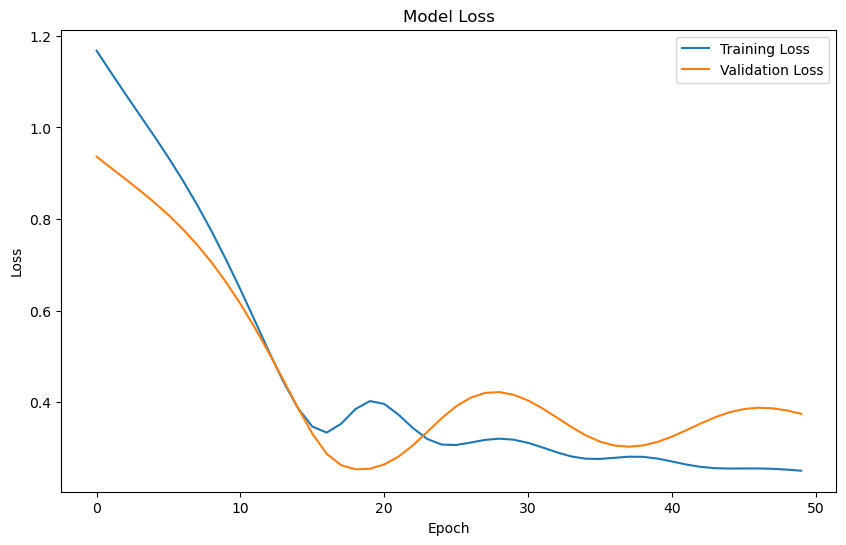

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

def load_and_prepare_data(file_path, column_name, seq_length, test_size=0.2, val_size=0.2):
    try:
        # Load data from Excel file
        data = pd.read_excel(file_path)

        # Extract specified column
        if column_name not in data.columns:
            raise ValueError(f"Column '{column_name}' not found in the Excel file.")

        raw_data = data[column_name].values

        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        normalized_data = scaler.fit_transform(raw_data.reshape(-1, 1))

        # Prepare sequences
        X, y = [], []
        for i in range(len(normalized_data) - seq_length):
            X.append(normalized_data[i:i+seq_length])
            y.append(normalized_data[i+seq_length])

        X, y = np.array(X), np.array(y)

        # Reshape X to be [samples, time steps, features]
        X = X.reshape(X.shape[0], X.shape[1], 1)

        # First, split into training+validation and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Then split the training set into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size, random_state=42)

        print(f"Training data shape: {X_train.shape}")
        print(f"Validation data shape: {X_val.shape}")
        print(f"Testing data shape: {X_test.shape}")

        return X_train, X_val, X_test, y_train, y_val, y_test, scaler

    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

def train_gru(X_train, y_train, X_val, y_val, input_dim, hidden_dim, epochs=50, learning_rate=0.001, batch_size=32):
    gru = GRUCell(input_dim, hidden_dim)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0

        # Training
        for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}/{epochs} (Training)"):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

            batch_loss = 0
            for j in range(len(batch_X)):
                x_seq = batch_X[j]
                y_true = batch_y[j]

                # Forward pass
                h = np.zeros((hidden_dim, 1))
                for t in range(x_seq.shape[0]):
                    x_t = x_seq[t].reshape(-1, 1)
                    h = gru.forward(x_t, h)

                # Calculate loss (mean squared error)
                y_pred = h[-1][0]
                loss = (y_true - y_pred)**2
                batch_loss += loss

                # Backward pass
                dh_next = 2 * (y_pred - y_true)
                for t in reversed(range(x_seq.shape[0])):
                    x_t = x_seq[t].reshape(-1, 1)
                    dh_next = gru.backward(dh_next)

            # Update weights
            gru.update_weights(learning_rate)
            total_train_loss += batch_loss

        # Validation
        for i in range(len(X_val)):
            x_seq = X_val[i]
            y_true = y_val[i]

            # Forward pass
            h = np.zeros((hidden_dim, 1))
            for t in range(x_seq.shape[0]):
                x_t = x_seq[t].reshape(-1, 1)
                h = gru.forward(x_t, h)

            # Calculate loss
            y_pred = h[-1][0]
            loss = (y_true - y_pred)**2
            total_val_loss += loss

        # Record losses
        avg_train_loss = float(np.mean(total_train_loss))
        avg_val_loss = float(np.mean(total_val_loss))
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return gru, history

# Usage
file_path = 'test.xlsx'
column_name = 'Terakhir_IDR'
seq_length = 10

X_train, X_val, X_test, y_train, y_val, y_test, scaler = load_and_prepare_data(file_path, column_name, seq_length)

input_dim = X_train.shape[2]
hidden_dim = 100
gru, history = train_gru(X_train, y_train, X_val, y_val, input_dim, hidden_dim)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import pickle

# Fungsi untuk menyimpan model dan scaler
def save_model(gru, scaler, filename_model, filename_scaler):
    with open(filename_model, 'wb') as f_model:
        pickle.dump(gru, f_model)
    with open(filename_scaler, 'wb') as f_scaler:
        pickle.dump(scaler, f_scaler)

# Fungsi untuk memuat model dan scaler
def load_model(filename_model, filename_scaler):
    with open(filename_model, 'rb') as f_model:
        gru = pickle.load(f_model)
    with open(filename_scaler, 'rb') as f_scaler:
        scaler = pickle.load(f_scaler)
    return gru, scaler

# Simpan model dan scaler setelah pelatihan
save_model(gru, scaler, 'gru_model.pkl', 'scaler.pkl')

# Contoh memuat model dan scaler
loaded_gru, loaded_scaler = load_model('gru_model.pkl', 'scaler.pkl')


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler

# Fungsi tambahan untuk menghitung MAPE dan MPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_percentage_error(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

# Load the scaler and model
with open('gru_model.pkl', 'rb') as f:
    loaded_gru = pickle.load(f)

# Define the file paths and parameters
file_path = 'hasil_prediksi.xlsx'  # Path to your uploaded test data file
output_file_path = 'prediksi_hasil.xlsx'
seq_length = 10

# Load and prepare the test data
test_data = pd.read_excel(file_path)
test_data['Tanggal'] = pd.to_datetime(test_data['Tanggal'], format='%d/%m/%Y')  # Adjust the format to match your data
test_data_close = test_data['Terakhir_IDR'].values  # Adjust the column name as needed

# Fit the scaler with test data (or load pre-fitted scaler if available)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(test_data_close.reshape(-1, 1))  # Fit the scaler with the test data

# Normalize test data using the fitted scaler
test_data_normalized = scaler.transform(test_data_close.reshape(-1, 1))

# Fungsi prediksi
def make_predictions(model, data, seq_length):
    predictions = []
    h = np.zeros((model.hidden_dim, 1))  # Initial hidden state
    for i in range(len(data) - seq_length):
        x_seq = data[i:i + seq_length]
        for t in range(seq_length):
            x_t = x_seq[t].reshape(-1, 1)
            h = model.forward(x_t, h)
        y_pred = h[-1][0]
        predictions.append(y_pred)
    return np.array(predictions)

# Buat prediksi
predictions = make_predictions(loaded_gru, test_data_normalized, seq_length)

# Denormalisasi hasil prediksi
predictions_denormalized = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Buat dataframe hasil prediksi
results = pd.DataFrame({
    'Tanggal': test_data['Tanggal'][seq_length:].values[:len(predictions)],
    'data_close': test_data_close[seq_length:][:len(predictions)],
    'prediksi_close': predictions_denormalized,
})

# Hitung selisih dan persentase selisih
results['selisih'] = results['data_close'] - results['prediksi_close']
results['persentase_selisih'] = (results['selisih'] / results['data_close']) * 100

# Hitung MAE, RMSE, MAPE, dan MPE
mae = mean_absolute_error(results['data_close'], results['prediksi_close'])
rmse = np.sqrt(mean_squared_error(results['data_close'], results['prediksi_close']))
mape = mean_absolute_percentage_error(results['data_close'], results['prediksi_close'])
mpe = mean_percentage_error(results['data_close'], results['prediksi_close'])

# Buat dataframe untuk menampilkan hasil metrik
metrics = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'MPE'],
    'Value': [mae, rmse, mape, mpe]
})

# Tampilkan dataframe metrik dalam Jupyter Notebook
metrics
# Simpan hasil prediksi
results.to_excel(output_file_path, index=False)
print(f"Hasil prediksi telah disimpan ke {output_file_path}")

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(results['Tanggal'], results['data_close'], label='Aktual')
plt.plot(results['Tanggal'], results['prediksi_close'], label='Prediksi')

# Menampilkan tanggal hanya dengan bulan dan tahun untuk menghindari overlap
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))

plt.title('Perbandingan Harga Aktual vs Prediksi GRU')
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_data(file_path):
    # Memuat data cryptocurrency dari file Excel
    data = pd.read_excel(file_path)
    data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%d/%m/%Y')
    data.set_index('Tanggal', inplace=True)
    return data

def calculate_moving_averages(data, short_window, long_window):
    # Menghitung moving average jangka pendek dan jangka panjang
    data['Short_MA'] = data['Terakhir_IDR'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Terakhir_IDR'].rolling(window=long_window, min_periods=1).mean()
    return data

def predict_dma(data, short_window, long_window, prediction_window):
    # Memprediksi tren masa depan berdasarkan DMA
    short_ma_future = [data['Short_MA'].iloc[-1]] * prediction_window
    long_ma_future = [data['Long_MA'].iloc[-1]] * prediction_window
    return short_ma_future, long_ma_future

def save_to_excel(data, output_file_path):
    # Menyimpan data yang telah diproses ke file Excel
    data.to_excel(output_file_path, index=True)

def plot_data(data, short_window, long_window, short_ma_future, long_ma_future):
    # Memplot harga penutupan dan moving average
    plt.figure(figsize=(14, 7))
    plt.plot(data['Terakhir_IDR'], label='Close Price')
    plt.plot(data['Short_MA'], label=f'Short-Term MA ({short_window} days)')
    plt.plot(data['Long_MA'], label=f'Long-Term MA ({long_window} days)')

    # Menyiapkan tanggal untuk prediksi moving average
    future_dates = pd.date_range(start=data.index[-1], periods=len(short_ma_future) + 1, freq='D')[1:]
    plt.plot(future_dates, short_ma_future, '--', label='Predicted Short-Term MA')
    plt.plot(future_dates, long_ma_future, '--', label='Predicted Long-Term MA')

    # Menambahkan judul dan label pada plot
    plt.title('Cryptocurrency Price with Double Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price (IDR)')
    plt.legend()
    plt.show()

# Fungsi tambahan untuk menghitung MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Jalur file ke file Excel
file_path = 'hasil_prediksi.xlsx'
output_file_path = 'hasil_dma.xlsx'
short_window = 40
long_window = 100
prediction_window = 10  # Jumlah hari untuk prediksi

# Memuat data
data = load_data(file_path)

# Menghitung moving averages
data = calculate_moving_averages(data, short_window, long_window)

# Menambahkan kolom selisih dan persentase selisih antara Short MA dan Long MA dengan harga asli
data['Selisih_Short_MA'] = data['Terakhir_IDR'] - data['Short_MA']
data['Persentase_Selisih_Short_MA'] = (data['Selisih_Short_MA'] / data['Terakhir_IDR']) * 100

data['Selisih_Long_MA'] = data['Terakhir_IDR'] - data['Long_MA']
data['Persentase_Selisih_Long_MA'] = (data['Selisih_Long_MA'] / data['Terakhir_IDR']) * 100

# Menghitung metrik
metrics = {
    'MAE_Short_MA': mean_absolute_error(data['Terakhir_IDR'], data['Short_MA']),
    'RMSE_Short_MA': np.sqrt(mean_squared_error(data['Terakhir_IDR'], data['Short_MA'])),
    'MAPE_Short_MA': mean_absolute_percentage_error(data['Terakhir_IDR'], data['Short_MA']),
    'MSE_Short_MA': mean_squared_error(data['Terakhir_IDR'], data['Short_MA']),
    'MAE_Long_MA': mean_absolute_error(data['Terakhir_IDR'], data['Long_MA']),
    'RMSE_Long_MA': np.sqrt(mean_squared_error(data['Terakhir_IDR'], data['Long_MA'])),
    'MAPE_Long_MA': mean_absolute_percentage_error(data['Terakhir_IDR'], data['Long_MA']),
    'MSE_Long_MA': mean_squared_error(data['Terakhir_IDR'], data['Long_MA']),
}

metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Menyimpan data yang telah diproses ke file Excel baru
save_to_excel(data, output_file_path)

# Memplot data
plot_data(data, short_window, long_window, short_ma_future, long_ma_future)

metrics_df



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Buat prediksi menggunakan model GRU yang sudah dimuat
gru_predictions = make_predictions(loaded_gru, test_data_normalized, seq_length)
gru_predictions_denormalized = scaler.inverse_transform(gru_predictions.reshape(-1, 1)).flatten()

# Hitung DMA (Double Moving Average)
data = calculate_moving_averages(test_data, short_window, long_window)
predictions_denormalized = data['Short_MA'].iloc[seq_length:].values

# Update dataframe hasil dengan prediksi GRU dan DMA
results = pd.DataFrame({
    'Tanggal': test_data['Tanggal'][seq_length:].values,
    'data_close': test_data_close[seq_length:],
    'prediksi_close_dma': predictions_denormalized,
    'prediksi_close_gru': gru_predictions_denormalized,
})

# Hitung selisih dan persentase selisih
results['selisih_dma'] = results['data_close'] - results['prediksi_close_dma']
results['persentase_selisih_dma'] = (results['selisih_dma'] / results['data_close']) * 100
results['selisih_gru'] = results['data_close'] - results['prediksi_close_gru']
results['persentase_selisih_gru'] = (results['selisih_gru'] / results['data_close']) * 100

# Hitung metrik kinerja
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_percentage_error(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

mae_dma = mean_absolute_error(results['data_close'], results['prediksi_close_dma'])
rmse_dma = np.sqrt(mean_squared_error(results['data_close'], results['prediksi_close_dma']))
mape_dma = mean_absolute_percentage_error(results['data_close'], results['prediksi_close_dma'])
mpe_dma = mean_percentage_error(results['data_close'], results['prediksi_close_dma'])

mae_gru = mean_absolute_error(results['data_close'], results['prediksi_close_gru'])
rmse_gru = np.sqrt(mean_squared_error(results['data_close'], results['prediksi_close_gru']))
mape_gru = mean_absolute_percentage_error(results['data_close'], results['prediksi_close_gru'])
mpe_gru = mean_percentage_error(results['data_close'], results['prediksi_close_gru'])

# Tabel perbandingan metrik kinerja
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'MPE'],
    'DMA': [mae_dma, rmse_dma, mape_dma, mpe_dma],
    'GRU': [mae_gru, rmse_gru, mape_gru, mpe_gru]
})

# Simpan hasil prediksi dan perbandingan metrik ke file Excel
with pd.ExcelWriter(output_file_path) as writer:
    results.to_excel(writer, sheet_name='Predictions', index=False)
    metrics_comparison.to_excel(writer, sheet_name='Metrics_Comparison', index=False)

print(f"Hasil prediksi dan perbandingan metrik telah disimpan ke {output_file_path}")

# Visualisasi perbandingan prediksi
plt.figure(figsize=(14, 7))
plt.plot(results['Tanggal'], results['data_close'], label='Actual Close Price')
plt.plot(results['Tanggal'], results['prediksi_close_dma'], label='DMA Predicted Close Price')
plt.plot(results['Tanggal'], results['prediksi_close_gru'], label='GRU Predicted Close Price')

plt.title('Perbandingan Prediksi DMA dan GRU untuk harga USDT Tether Coin')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

metrics_comparison
